In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.stats import kendalltau
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
import sqlite3

In [2]:
db_path = "/Users/alexdubro/.cache/kagglehub/datasets/rtatman/188-million-us-wildfires/versions/2/FPA_FOD_20170508.sqlite"

# Wildfire Analysis

## Introduction

From 1992 to 2015, the United States recorded an extraordinary wildfire story — and this dataset captures it in full geographic detail. Built as the third major update to support the national Fire Program Analysis (FPA) system, it brings together incident reports from federal, state, and local fire agencies into one unified spatial database.

To make the cut, every record had to include three essentials: when the fire was discovered, how large it ultimately became, and a mapped point location precise to at least the Public Land Survey System (PLSS) section level (a 1-square-mile grid). Records were standardized to align with National Wildfire Coordinating Group (NWCG) data conventions wherever possible, then screened for quality issues and duplicates.

The result is the Fire Program Analysis fire-occurrence database (FPA FOD): 1.88 million georeferenced wildfire incidents documenting roughly 140 million acres burned over 24 years — a powerful foundation for understanding wildfire patterns, risk, and impact across the U.S.

There's an enormous number of tables in this database. We will first look at the tables and then select the tables we need for our analysis.

In [3]:
# list tables
with sqlite3.connect(db_path) as conn:
    tables = pd.read_sql_query("""
        SELECT name
        FROM sqlite_master
        WHERE type='table'
        ORDER BY name;
    """, conn)

tables.head(20)

,name
0,ElementaryGeometries
1,Fires
2,KNN
3,NWCG_UnitIDActive_20170109
4,SpatialIndex
5,geometry_columns
6,geometry_columns_auth
7,geometry_columns_field_infos
8,geometry_columns_statistics
9,geometry_columns_time


In [4]:
# Get all table names and column names
table_to_columns = {}
skipped = {}

with sqlite3.connect(db_path) as conn:
    cur = conn.cursor()
    cur.execute("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;")
    tables = [r[0] for r in cur.fetchall()]

    for t in tables:
        try:
            cur.execute(f'PRAGMA table_info("{t}")')
            cols = [row[1] for row in cur.fetchall()]  # row[1] = column name
            if cols:  # keep only real tables with columns
                table_to_columns[t] = cols
        except Exception as e:
            skipped[t] = str(e)

# dictionary you asked for:
table_to_columns

{'Fires': ['OBJECTID',
  'FOD_ID',
  'FPA_ID',
  'SOURCE_SYSTEM_TYPE',
  'SOURCE_SYSTEM',
  'NWCG_REPORTING_AGENCY',
  'NWCG_REPORTING_UNIT_ID',
  'NWCG_REPORTING_UNIT_NAME',
  'SOURCE_REPORTING_UNIT',
  'SOURCE_REPORTING_UNIT_NAME',
  'LOCAL_FIRE_REPORT_ID',
  'LOCAL_INCIDENT_ID',
  'FIRE_CODE',
  'FIRE_NAME',
  'ICS_209_INCIDENT_NUMBER',
  'ICS_209_NAME',
  'MTBS_ID',
  'MTBS_FIRE_NAME',
  'COMPLEX_NAME',
  'FIRE_YEAR',
  'DISCOVERY_DATE',
  'DISCOVERY_DOY',
  'DISCOVERY_TIME',
  'STAT_CAUSE_CODE',
  'STAT_CAUSE_DESCR',
  'CONT_DATE',
  'CONT_DOY',
  'CONT_TIME',
  'FIRE_SIZE',
  'FIRE_SIZE_CLASS',
  'LATITUDE',
  'LONGITUDE',
  'OWNER_CODE',
  'OWNER_DESCR',
  'STATE',
  'COUNTY',
  'FIPS_CODE',
  'FIPS_NAME',
  'Shape'],
 'NWCG_UnitIDActive_20170109': ['OBJECTID',
  'UnitId',
  'GeographicArea',
  'Gacc',
  'WildlandRole',
  'UnitType',
  'Department',
  'Agency',
  'Parent',
  'Country',
  'State',
  'Code',
  'Name'],
 'geometry_columns': ['f_table_name',
  'f_geometry_column',
 

## Exploratory Data Analysis

### 1. How many wildfires occurred each year?

To begin our analysis, we will look at how many wildfires occurred each year, where, how large they were, and how many acres they burned.

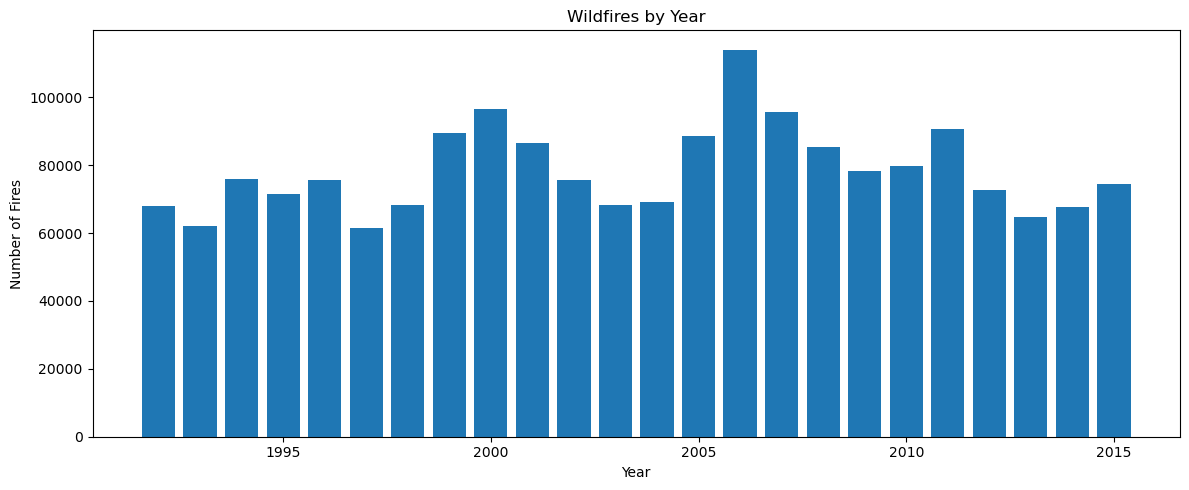

In [5]:
# Wildfire by year

df = pd.read_sql_query("""
SELECT
  FIRE_YEAR,
  COUNT(*) AS n_fires
FROM Fires
GROUP BY FIRE_YEAR
ORDER BY FIRE_YEAR;
""", conn)

df.head()

# Histogram-style bar chart by year
plt.figure(figsize=(12, 5))
plt.bar(df["FIRE_YEAR"], df["n_fires"])
plt.title("Wildfires by Year")
plt.xlabel("Year")
plt.ylabel("Number of Fires")
plt.tight_layout()
plt.show()

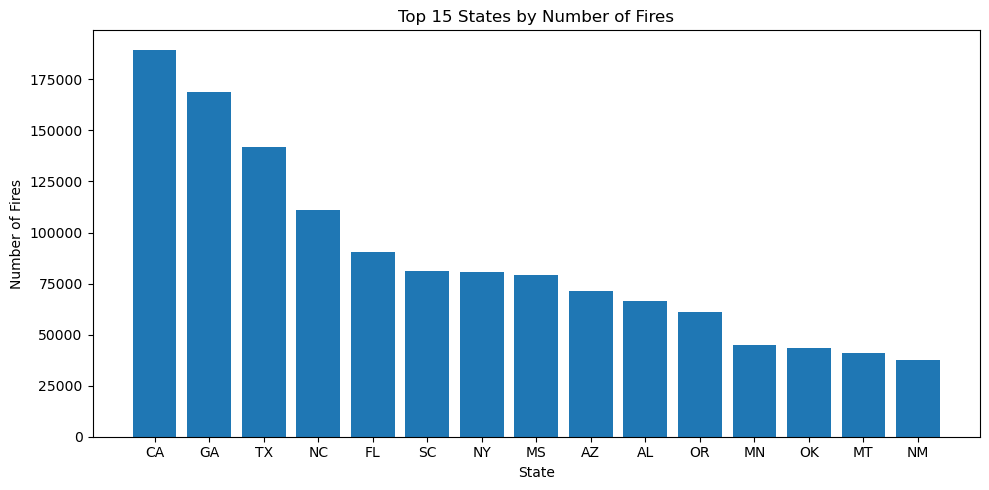

In [6]:
# Wildfire by state
df_year = pd.read_sql_query("""
SELECT
  FIRE_YEAR,
  COUNT(*) AS n_fires
FROM Fires
GROUP BY FIRE_YEAR
ORDER BY FIRE_YEAR;
""", conn)

df_year.head() 

# 2) Distribution by state (all years combined)
df_state = pd.read_sql_query("""
SELECT
  STATE,
  COUNT(*) AS n_fires
FROM Fires
GROUP BY STATE
ORDER BY n_fires DESC;
""", conn)

df_state.head()

# optional: remove null/blank states
plot_df = df_state.dropna(subset=["STATE"]).copy()
plot_df = plot_df[plot_df["STATE"].str.strip() != ""]

top_n = 15
top_df = plot_df.head(top_n)

plt.figure(figsize=(10, 5))
plt.bar(top_df["STATE"], top_df["n_fires"])
plt.title(f"Top {top_n} States by Number of Fires")
plt.xlabel("State")
plt.ylabel("Number of Fires")
plt.tight_layout()
plt.show()


In [7]:
# Distribution of wildfires by year and what state was most affected

df_year_state_pct = pd.read_sql_query("""
WITH year_state AS (
  SELECT
    FIRE_YEAR,
    STATE,
    COUNT(*) AS fires_in_state_year
  FROM Fires
  GROUP BY FIRE_YEAR, STATE
)
SELECT
  ys.FIRE_YEAR,
  ys.STATE,
  ys.fires_in_state_year,
  ROUND(
    100.0 * ys.fires_in_state_year
    / SUM(ys.fires_in_state_year) OVER (PARTITION BY ys.FIRE_YEAR),
    2
  ) AS pct_of_year
FROM year_state ys
ORDER BY ys.FIRE_YEAR, ys.fires_in_state_year DESC;
""", conn)

df_year_state_pct.head(5)

# --- settings ---
top_n = 8
out_dir = Path("yearly_pie_charts")
out_dir.mkdir(parents=True, exist_ok=True)

# clean data
plot_df = df_year_state_pct.dropna(subset=["STATE"]).copy()
plot_df = plot_df[plot_df["STATE"].str.strip() != ""]

years = sorted(plot_df["FIRE_YEAR"].unique())

for year in years:
    year_df = plot_df[plot_df["FIRE_YEAR"] == year].copy()
    year_df = year_df.sort_values("fires_in_state_year", ascending=False)

    top = year_df.head(top_n).copy()
    other_sum = year_df["fires_in_state_year"].iloc[top_n:].sum()

    if other_sum > 0:
        top = pd.concat(
            [top, pd.DataFrame([{
                "STATE": "Other",
                "fires_in_state_year": other_sum
            }])],
            ignore_index=True
        )

    plt.figure(figsize=(8, 8))
    plt.pie(
        top["fires_in_state_year"],
        labels=top["STATE"],
        autopct="%1.1f%%",
        startangle=90
    )
    plt.title(f"Wildfire Share by State — {year} (Top {top_n} + Other)")
    plt.tight_layout()

    file_path = out_dir / f"wildfire_share_{year}.png"
    plt.savefig(file_path, dpi=150)
    plt.close()

print(f"Saved {len(years)} charts to: {out_dir.resolve()}")

Saved 24 charts to: /Users/alexdubro/Documents/Programming Tools/STARTING 2-1-26/wildires_in_the_states/yearly_pie_charts


The question -- have wildfires become more common in the United States -- is more complex than it may seem. While it may seem like wildfires have remained common throughout the years, we should also look at the share of the most common states. Has it been decreasing over time?

In [8]:
df_top1_share = pd.read_sql_query("""
WITH year_state AS (
  SELECT FIRE_YEAR, STATE, COUNT(*) AS n
  FROM Fires
  GROUP BY FIRE_YEAR, STATE
),
ranked AS (
  SELECT
    FIRE_YEAR,
    STATE,
    n,
    ROW_NUMBER() OVER (PARTITION BY FIRE_YEAR ORDER BY n DESC) AS rn,
    SUM(n) OVER (PARTITION BY FIRE_YEAR) AS year_total
  FROM year_state
)
SELECT
  FIRE_YEAR,
  STATE AS top_state,
  n AS top_state_fires,
  ROUND(100.0 * n / year_total, 2) AS top1_share_pct
FROM ranked
WHERE rn = 1
ORDER BY FIRE_YEAR;
""", conn) 
df_top1_share.head()

,FIRE_YEAR,top_state,top_state_fires,top1_share_pct
0,1992,CA,10833,15.94
1,1993,GA,9111,14.70
2,1994,CA,8654,11.39
3,1995,GA,7968,11.15
4,1996,GA,9872,13.06


    FIRE_YEAR  top3_share_pct  top5_share_pct
0        1992           33.82           48.05
1        1993           36.57           51.81
2        1994           27.62           39.48
3        1995           28.83           42.11
4        1996           31.71           43.77
5        1997           32.02           43.38
6        1998           27.76           39.30
7        1999           28.57           40.68
8        2000           26.46           39.70
9        2001           29.91           42.74
10       2002           27.13           37.96
11       2003           25.51           35.65
12       2004           28.71           39.79
13       2005           24.02           35.67
14       2006           28.26           38.93
15       2007           27.36           39.71
16       2008           38.61           50.55
17       2009           34.28           43.84
18       2010           26.79           39.16
19       2011           40.23           51.78
20       2012           27.18     

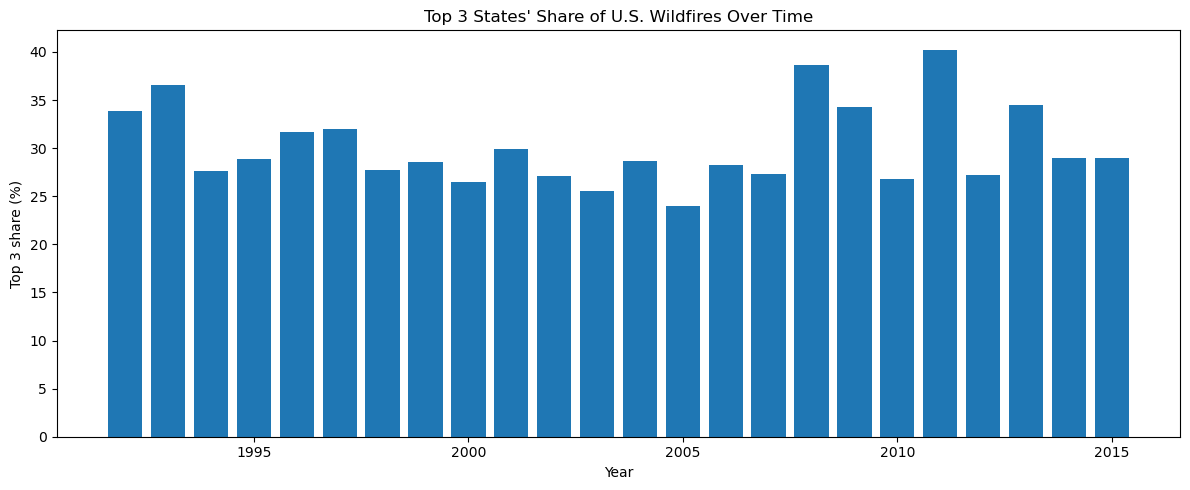

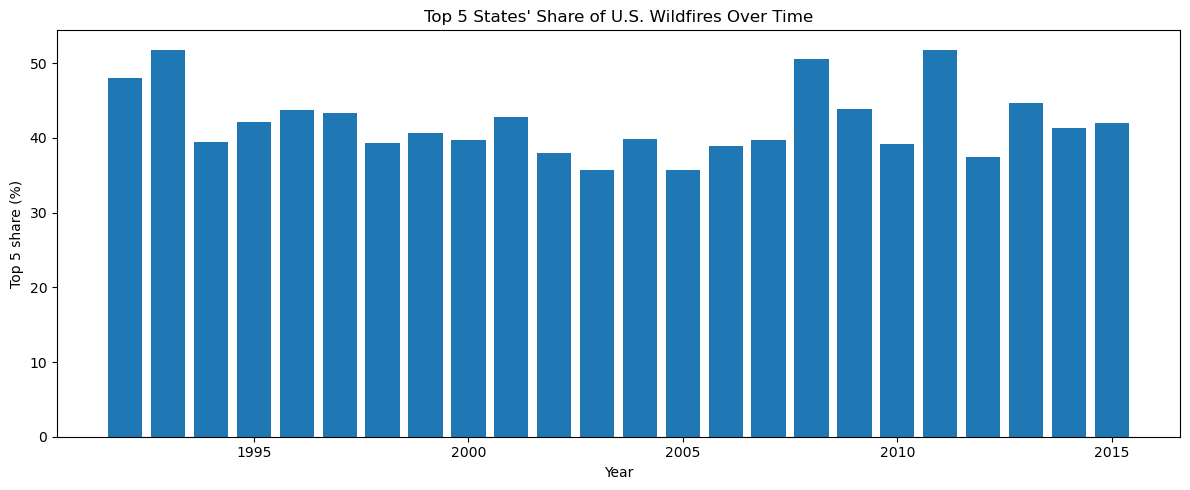

In [9]:
df_topk_share = pd.read_sql_query("""
WITH year_state AS (
  SELECT FIRE_YEAR, STATE, COUNT(*) AS n
  FROM Fires
  GROUP BY FIRE_YEAR, STATE
),
ranked AS (
  SELECT
    FIRE_YEAR,
    STATE,
    n,
    ROW_NUMBER() OVER (PARTITION BY FIRE_YEAR ORDER BY n DESC) AS rn,
    SUM(n) OVER (PARTITION BY FIRE_YEAR) AS year_total
  FROM year_state
)
SELECT
  FIRE_YEAR,
  ROUND(100.0 * SUM(CASE WHEN rn <= 3 THEN n ELSE 0 END) / MAX(year_total), 2) AS top3_share_pct,
  ROUND(100.0 * SUM(CASE WHEN rn <= 5 THEN n ELSE 0 END) / MAX(year_total), 2) AS top5_share_pct
FROM ranked
GROUP BY FIRE_YEAR
ORDER BY FIRE_YEAR;
""", conn)

print(df_topk_share)

# Top 3 share over time
plt.figure(figsize=(12, 5))
plt.bar(df_topk_share["FIRE_YEAR"], df_topk_share["top3_share_pct"])
plt.title("Top 3 States' Share of U.S. Wildfires Over Time")
plt.xlabel("Year")
plt.ylabel("Top 3 share (%)")
plt.tight_layout()
plt.show()

# Top 5 share over time
plt.figure(figsize=(12, 5))
plt.bar(df_topk_share["FIRE_YEAR"], df_topk_share["top5_share_pct"])
plt.title("Top 5 States' Share of U.S. Wildfires Over Time")
plt.xlabel("Year")
plt.ylabel("Top 5 share (%)")
plt.tight_layout()
plt.show()

So we see that the share of the top 3 and top 5 states hasn't changed much over time either. 

The last thing we can ask if there is a monotonic relationship between the number of wildfires and the year. With that, we will use the Mann–Kendall test to see if there is a monotonic relationship between the number of wildfires and the year over time.

In [10]:
df_total = pd.read_sql_query("""
SELECT
  FIRE_YEAR,
  COUNT(*) AS total_fires
FROM Fires
GROUP BY FIRE_YEAR
ORDER BY FIRE_YEAR;
""", conn)

tau, p = kendalltau(df_total["FIRE_YEAR"], df_total["total_fires"])
print(tau, p)

0.10869565217391304 0.4760860141131976


The p-value is 0.476, which is not significant, so we can't reject the null hypothesis. This means that there is no monotonic relationship between the number of wildfires and the year over time.

Simply, the number of wildfires has not changed much over time.

### 2. What counties have the most wildfires?

Equally important is knowing which counies are most and least fire-prone.

This is a very tough question to answer. 

Why?

• Because wildfires are sometimes natural (lightning, etc.) and sometimes human-caused (campfires, etc.). 
• Because wildfires can sometimes be seasonal.
• Because wildfires can sometimes be more severe once they start.
• Because wildfires can sometimes happen more often in one year than another.
• Because wildfires can sometimes happen every year and sometimes not.
• Because wildfires can sometimes happen in one state and not another.
• Because wildfires can sometimes experience a monotonic increase in severity or frequency.

Therefore, we'll need to be careful about how we answer this question.

We'll use a composite composite county fire-proneness index to answer this question:
• Number of wildfires in total
• Number of years that there was a wildfire
• Number of wildfires max in a year
• Number of acres burned
• Percent of of wildfires that were human-caused vs. natural

Let's remember that this dataset accounts for counties that have at least one wildfire in the period.

To calculate that index, we will look at each county (1992–2015) and calculate:

1) Frequency
• Total wildfires
• Max wildfires in a single year

2) Persistence
• Number (or %) of years with at least one wildfire

3) Severity
• Total acres burned

4) Cause mix
• % natural-caused fires (lightning)
• % human-caused fires

To score counties, we will:
1) Convert each component to a common scale (e.g., percentile or min-max 0–100).
2) Apply weights (example below).
3) Sum weighted components into one score.

Then, we will rank counties highest to lowest.

We will use the following weights:
• 30% total wildfires
• 20% years with wildfire (persistence)
• 15% max wildfires in a year
• 25% acres burned
• 10% cause mix (natural vs human; depending on your research goal)

In [11]:
with sqlite3.connect(db_path) as conn:
    q_composite_top_bottom = """
    WITH base AS (
      SELECT
        FIRE_YEAR,
        STATE,
        substr('00000' || TRIM(FIPS_CODE), -5, 5) AS fips5,
        COALESCE(NULLIF(TRIM(FIPS_NAME), ''), NULLIF(TRIM(COUNTY), '')) AS county_name,
        COALESCE(FIRE_SIZE, 0.0) AS fire_size,
        STAT_CAUSE_DESCR
      FROM Fires
      WHERE FIRE_YEAR BETWEEN 1992 AND 2015
        AND FIPS_CODE IS NOT NULL
        AND TRIM(FIPS_CODE) <> ''
    ),
    county_year AS (
      SELECT
        STATE,
        fips5,
        FIRE_YEAR,
        COUNT(*) AS fires_in_year
      FROM base
      GROUP BY STATE, fips5, FIRE_YEAR
    ),
    county_rollup AS (
      SELECT
        b.STATE,
        b.fips5,
        MAX(b.county_name) AS county_name,
        COUNT(*) AS total_wildfires,
        SUM(b.fire_size) AS acres_burned,
        SUM(CASE WHEN b.STAT_CAUSE_DESCR = 'Lightning' THEN 1 ELSE 0 END) AS natural_fires,
        SUM(CASE WHEN b.STAT_CAUSE_DESCR IS NULL OR b.STAT_CAUSE_DESCR <> 'Lightning' THEN 1 ELSE 0 END) AS human_fires
      FROM base b
      GROUP BY b.STATE, b.fips5
    ),
    county_persistence AS (
      SELECT
        STATE,
        fips5,
        COUNT(*) AS years_with_wildfire,
        MAX(fires_in_year) AS max_wildfires_in_year
      FROM county_year
      GROUP BY STATE, fips5
    ),
    metrics AS (
      SELECT
        r.STATE,
        r.fips5,
        r.county_name,
        r.total_wildfires,
        p.years_with_wildfire,
        p.max_wildfires_in_year,
        r.acres_burned,
        1.0 * r.natural_fires / NULLIF(r.total_wildfires, 0) AS natural_share,
        1.0 * r.human_fires   / NULLIF(r.total_wildfires, 0) AS human_share
      FROM county_rollup r
      JOIN county_persistence p
        ON r.STATE = p.STATE AND r.fips5 = p.fips5
      WHERE r.total_wildfires > 0
      -- optional stability filter:
      -- AND r.total_wildfires >= 25
    ),
    bounds AS (
      SELECT
        MIN(total_wildfires) AS min_tw, MAX(total_wildfires) AS max_tw,
        MIN(years_with_wildfire) AS min_yw, MAX(years_with_wildfire) AS max_yw,
        MIN(max_wildfires_in_year) AS min_mw, MAX(max_wildfires_in_year) AS max_mw,
        MIN(acres_burned) AS min_ab, MAX(acres_burned) AS max_ab,
        MIN(natural_share) AS min_ns, MAX(natural_share) AS max_ns
      FROM metrics
    ),
    ranked AS (
      SELECT
        m.STATE,
        m.fips5 AS fips_code,
        m.county_name,
        m.total_wildfires,
        m.years_with_wildfire,
        m.max_wildfires_in_year,
        ROUND(m.acres_burned, 2) AS acres_burned,
        ROUND(100.0 * m.natural_share, 2) AS natural_pct,
        ROUND(100.0 * m.human_share, 2) AS human_pct,
        ROUND(
          0.30 * ((m.total_wildfires - b.min_tw) / NULLIF(b.max_tw - b.min_tw, 0)) +
          0.20 * ((m.years_with_wildfire - b.min_yw) / NULLIF(b.max_yw - b.min_yw, 0)) +
          0.15 * ((m.max_wildfires_in_year - b.min_mw) / NULLIF(b.max_mw - b.min_mw, 0)) +
          0.25 * ((m.acres_burned - b.min_ab) / NULLIF(b.max_ab - b.min_ab, 0)) +
          0.10 * ((m.natural_share - b.min_ns) / NULLIF(b.max_ns - b.min_ns, 0))
        , 6) AS composite_score
      FROM metrics m
      CROSS JOIN bounds b
    ),
    top10 AS (
      SELECT 'TOP_10' AS bucket, *
      FROM ranked
      ORDER BY composite_score DESC
      LIMIT 10
    ),
    bottom10 AS (
      SELECT 'BOTTOM_10' AS bucket, *
      FROM ranked
      ORDER BY composite_score ASC
      LIMIT 10
    )
    SELECT * FROM top10
    UNION ALL
    SELECT * FROM bottom10
    ORDER BY bucket, composite_score DESC;
    """

    df_top_bottom = pd.read_sql_query(q_composite_top_bottom, conn)

df_top10 = df_top_bottom[df_top_bottom["bucket"] == "TOP_10"].reset_index(drop=True)
df_bottom10 = df_top_bottom[df_top_bottom["bucket"] == "BOTTOM_10"].reset_index(drop=True)

print("Top 10:")
print(df_top10)
print("\nBottom 10:")
print(df_bottom10)


Top 10:
   bucket STATE fips_code   county_name  total_wildfires  years_with_wildfire  \
0  TOP_10    AZ     00005      Coconino             7900                   24   
1  TOP_10    ID     00049         Idaho             4255                   24   
2  TOP_10    WA     00047      Okanogan             2653                   24   
3  TOP_10    NV     00007          Elko             1992                   19   
4  TOP_10    ID     00085        Valley             1466                   24   
5  TOP_10    MT     00075  Powder River              605                   24   
6  TOP_10    OR     00037          Lake             1708                   24   
7  TOP_10    OR     00023         Grant             2596                   24   
8  TOP_10    WA     00007        Chelan             1349                   24   
9  TOP_10    UT     00001        Beaver              735                   24   

   max_wildfires_in_year  acres_burned  natural_pct  human_pct  \
0                    673     42373

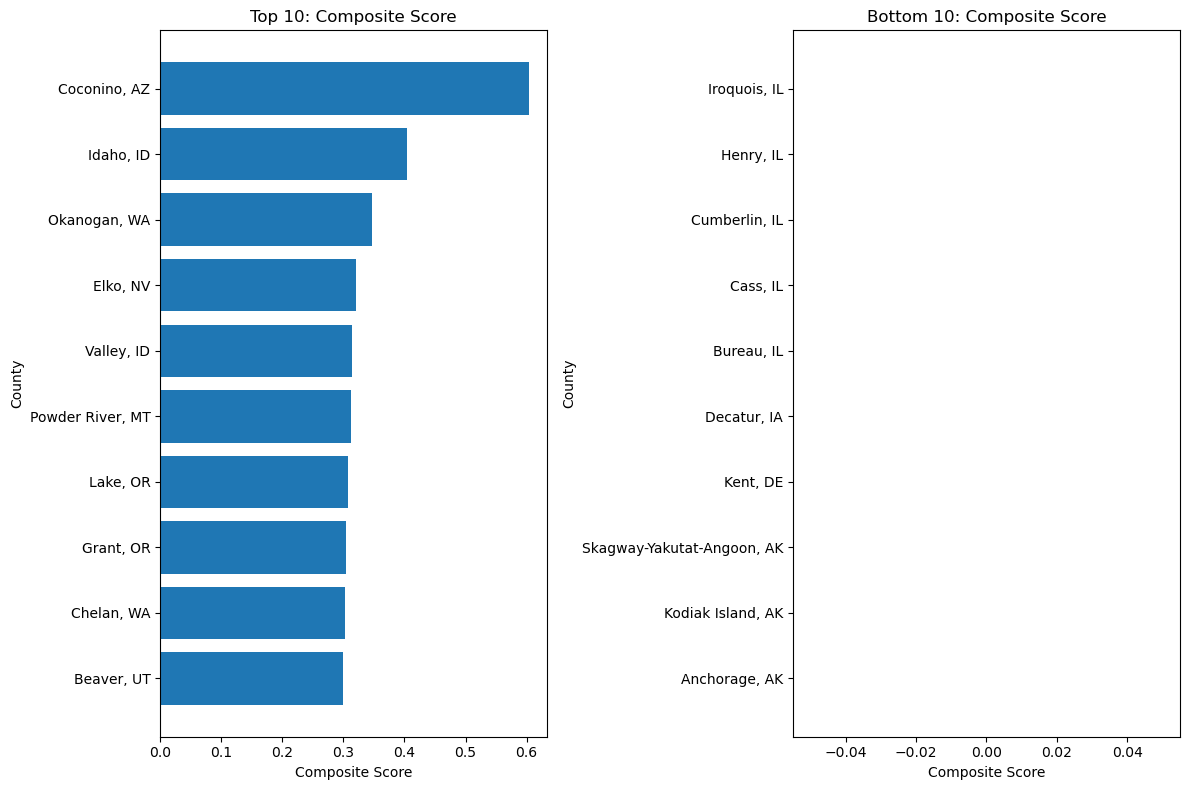

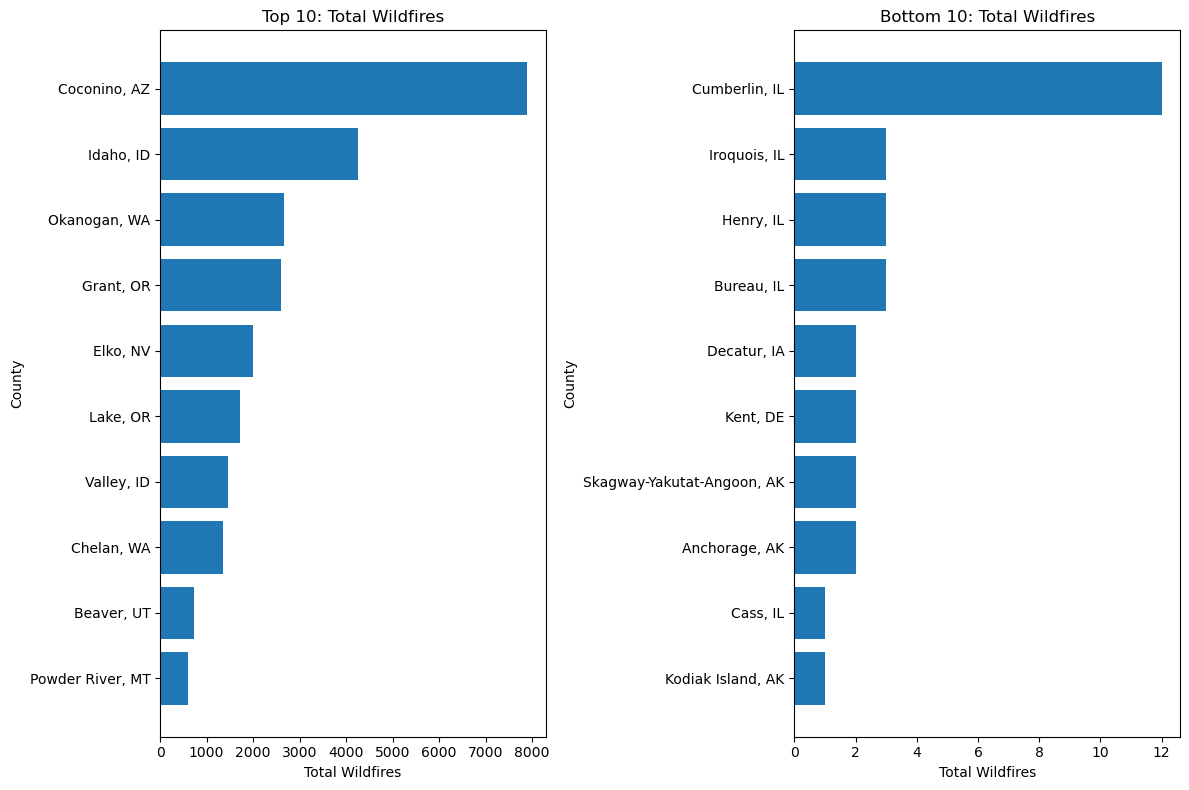

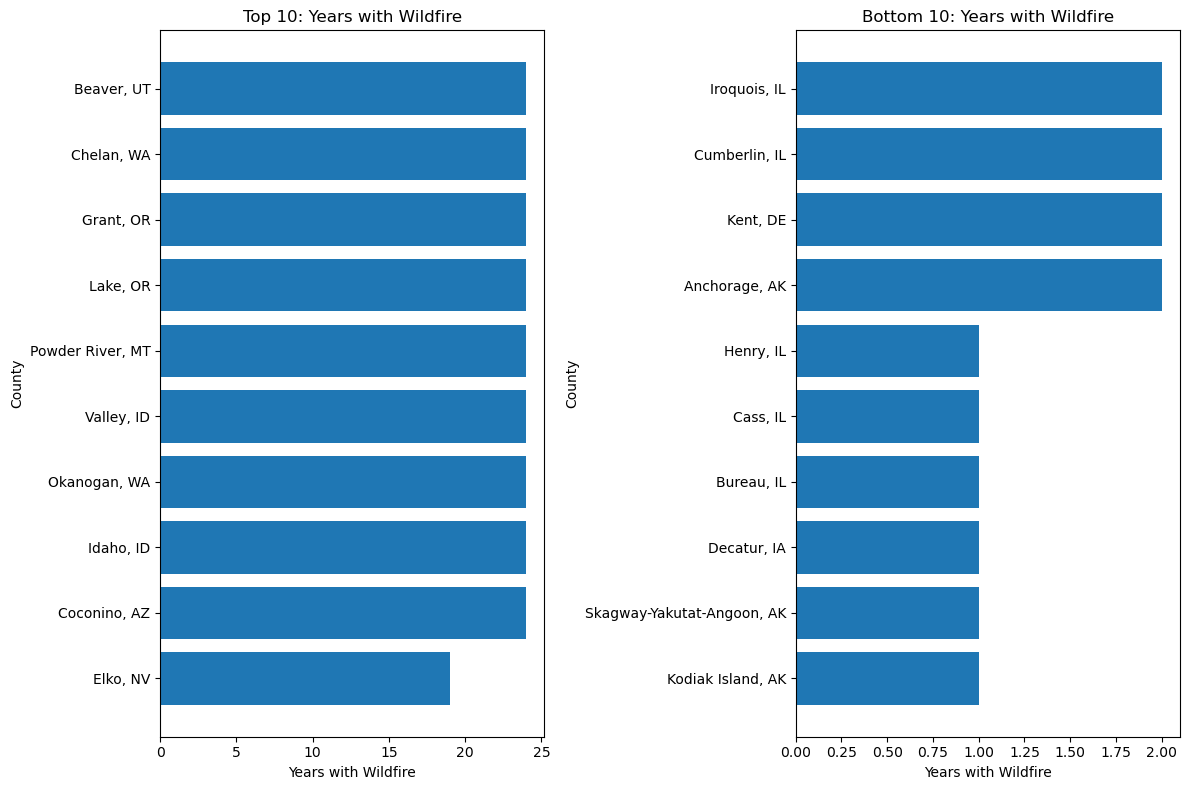

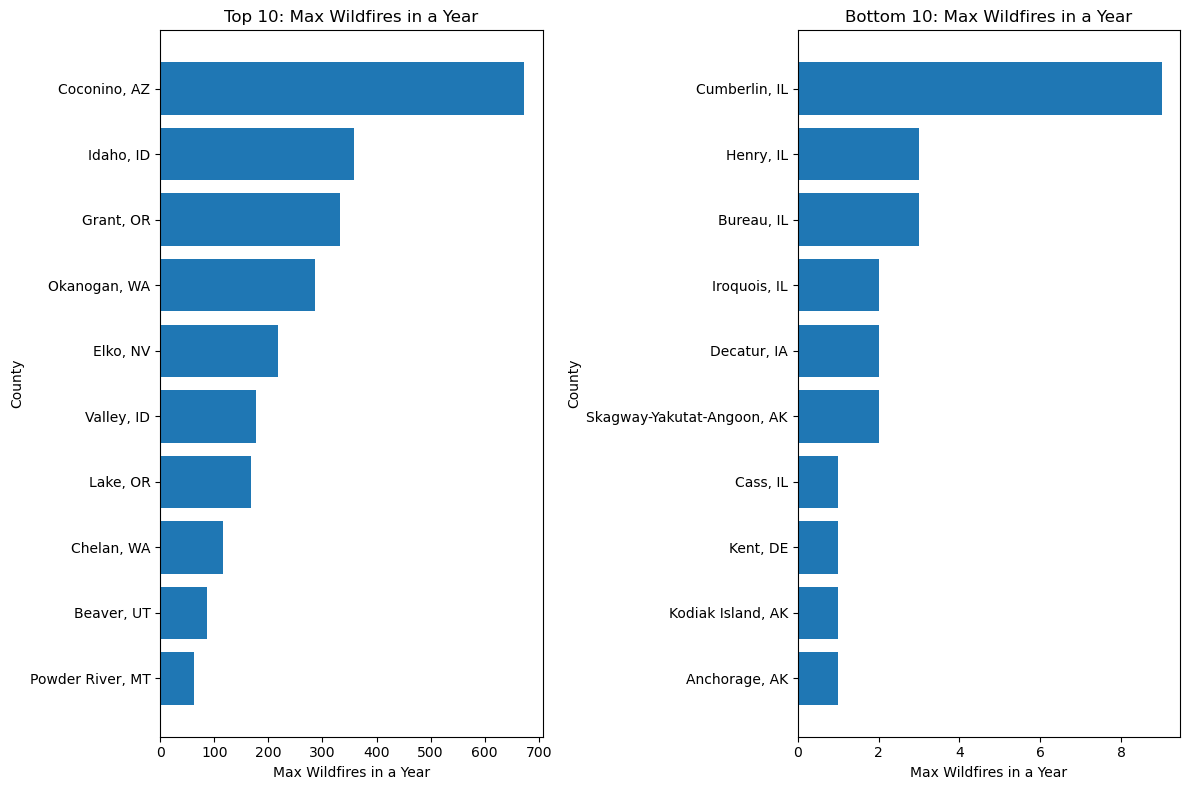

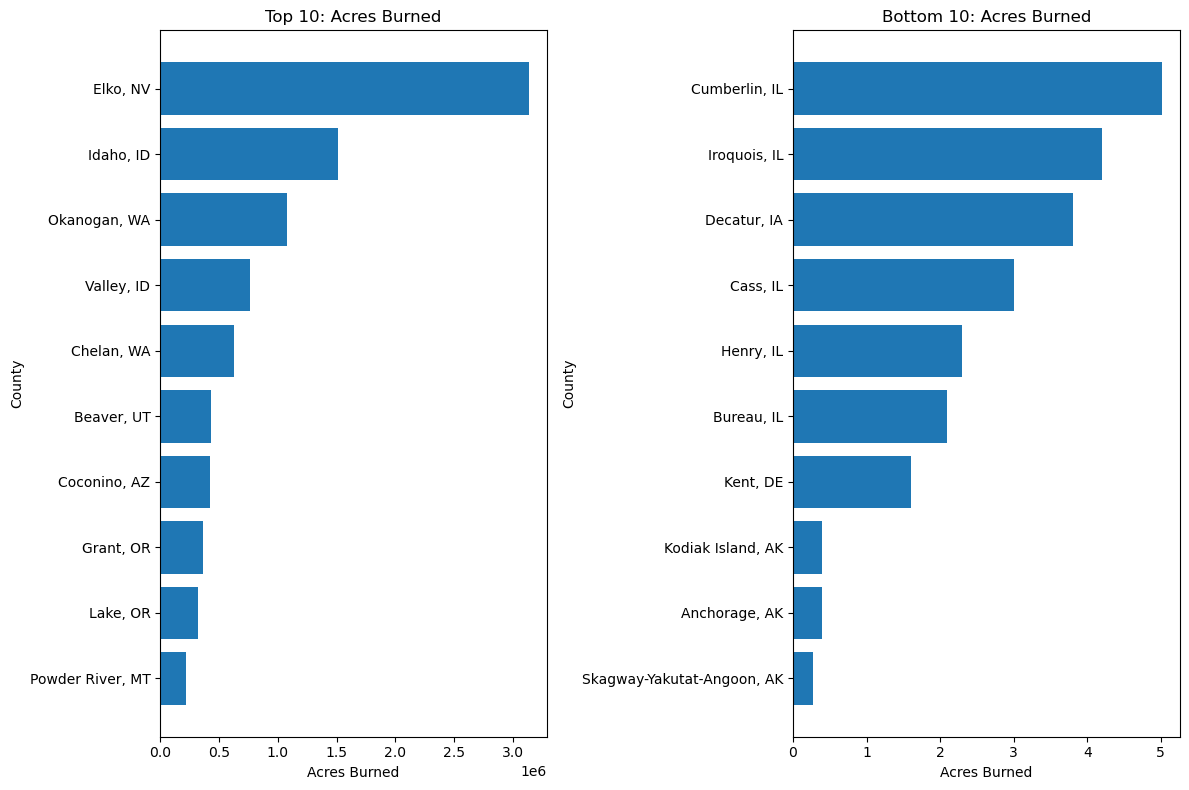

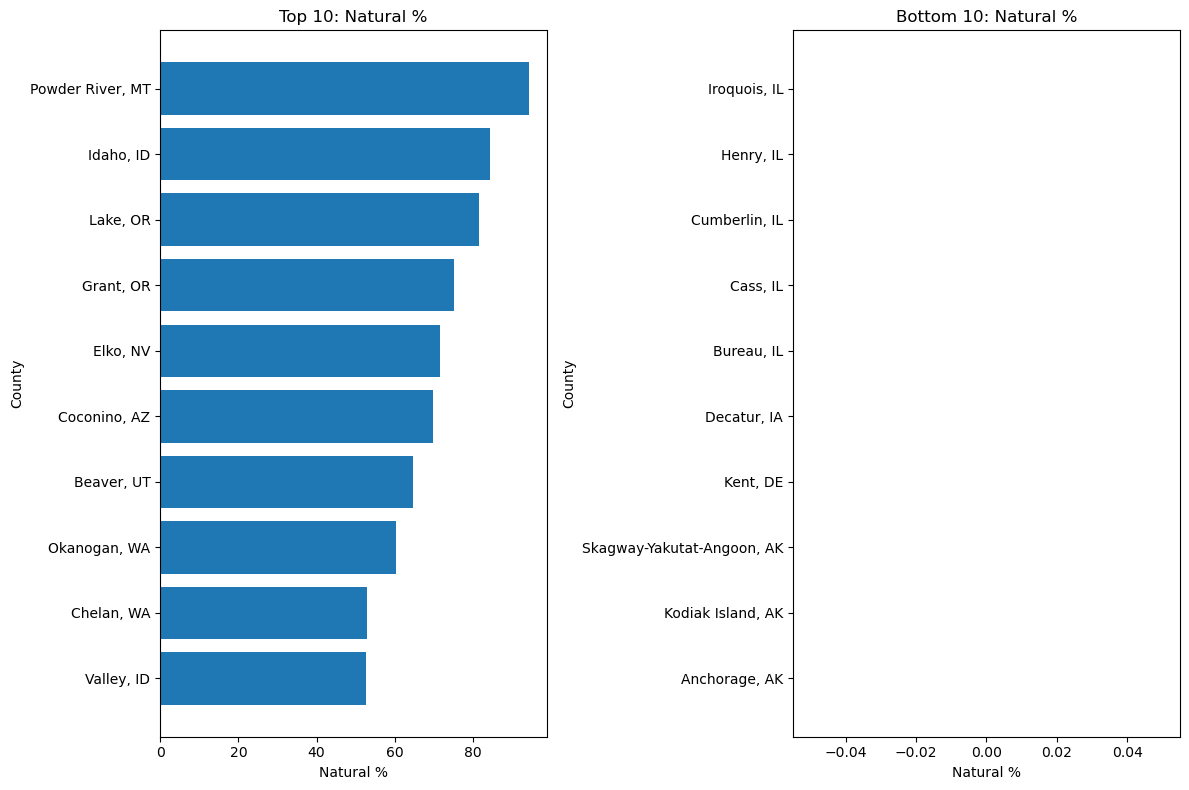

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Combine data
compare = pd.concat(
    [df_top10.assign(group="Top 10"), df_bottom10.assign(group="Bottom 10")],
    ignore_index=True
).copy()

compare["county_label"] = compare["county_name"].fillna("Unknown") + ", " + compare["STATE"].fillna("")
compare = compare.sort_values(["group", "composite_score"], ascending=[True, False])

metrics = [
    ("composite_score", "Composite Score"),
    ("total_wildfires", "Total Wildfires"),
    ("years_with_wildfire", "Years with Wildfire"),
    ("max_wildfires_in_year", "Max Wildfires in a Year"),
    ("acres_burned", "Acres Burned"),
    ("natural_pct", "Natural %")
]

# One chart per metric (clearer than cramming)
for col, title in metrics:
    top = compare[compare["group"] == "Top 10"].sort_values(col, ascending=True)
    bot = compare[compare["group"] == "Bottom 10"].sort_values(col, ascending=True)

    plt.figure(figsize=(12, 8))
    
    # Top 10 panel
    plt.subplot(1, 2, 1)
    plt.barh(top["county_label"], top[col])
    plt.title(f"Top 10: {title}")
    plt.xlabel(title)
    plt.ylabel("County")

    # Bottom 10 panel
    plt.subplot(1, 2, 2)
    plt.barh(bot["county_label"], bot[col])
    plt.title(f"Bottom 10: {title}")
    plt.xlabel(title)
    plt.ylabel("County")

    plt.tight_layout()
    plt.show()


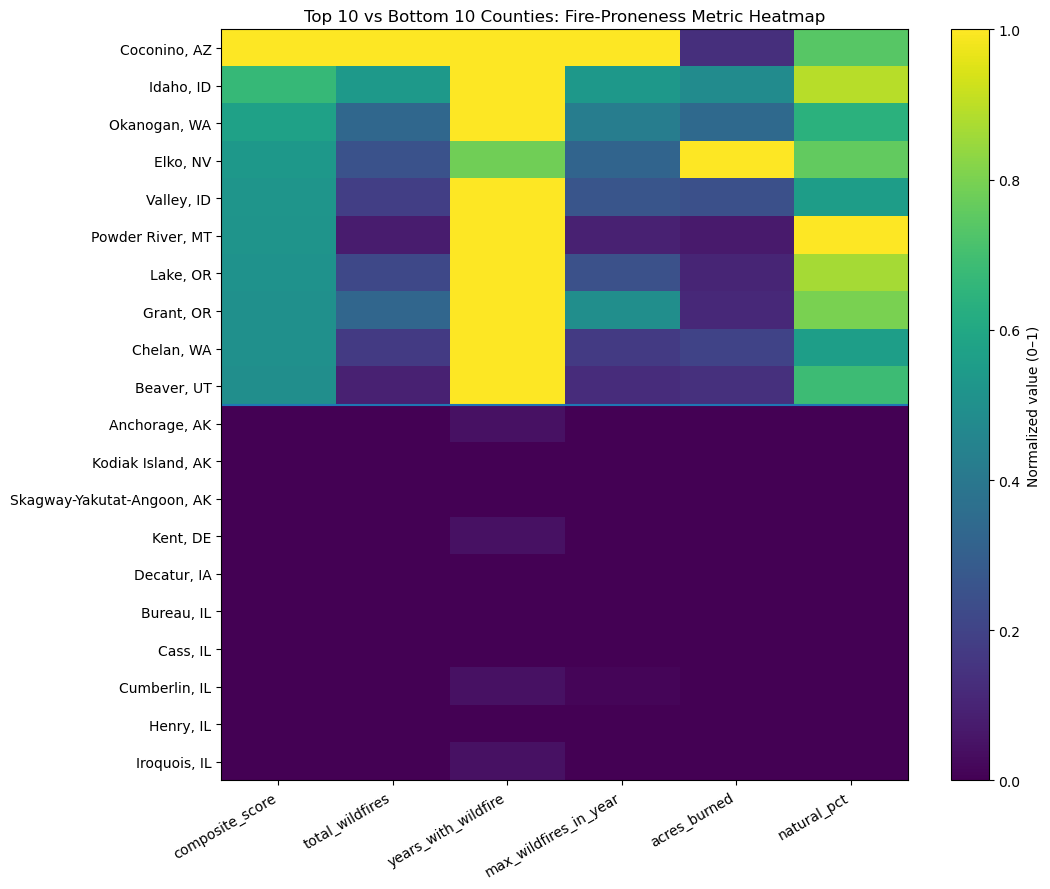

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Combine top and bottom
compare = pd.concat(
    [
        df_top10.assign(group="Top 10"),
        df_bottom10.assign(group="Bottom 10")
    ],
    ignore_index=True
)

# 2) County label
compare["county_label"] = compare["county_name"].fillna("Unknown") + ", " + compare["STATE"].fillna("")

# 3) Pick metrics for heatmap
metrics = [
    "composite_score",
    "total_wildfires",
    "years_with_wildfire",
    "max_wildfires_in_year",
    "acres_burned",
    "natural_pct"
]

# 4) Order rows: Top 10 (high->low), then Bottom 10 (low->high)
top_ord = compare[compare["group"] == "Top 10"].sort_values("composite_score", ascending=False)
bot_ord = compare[compare["group"] == "Bottom 10"].sort_values("composite_score", ascending=True)
plot_df = pd.concat([top_ord, bot_ord], ignore_index=True)

# 5) Normalize each metric column to [0,1] for comparability
heat_df = plot_df[metrics].astype(float).copy()
for c in metrics:
    cmin, cmax = heat_df[c].min(), heat_df[c].max()
    heat_df[c] = 0.0 if cmax == cmin else (heat_df[c] - cmin) / (cmax - cmin)

# 6) Plot
plt.figure(figsize=(11, 9))
img = plt.imshow(heat_df.values, aspect="auto")
plt.colorbar(img, label="Normalized value (0–1)")

plt.xticks(range(len(metrics)), metrics, rotation=30, ha="right")
plt.yticks(range(len(plot_df)), plot_df["county_label"])

# divider line between Top and Bottom blocks
split_idx = len(top_ord)
plt.axhline(split_idx - 0.5)

plt.title("Top 10 vs Bottom 10 Counties: Fire-Proneness Metric Heatmap")
plt.tight_layout()
plt.show()


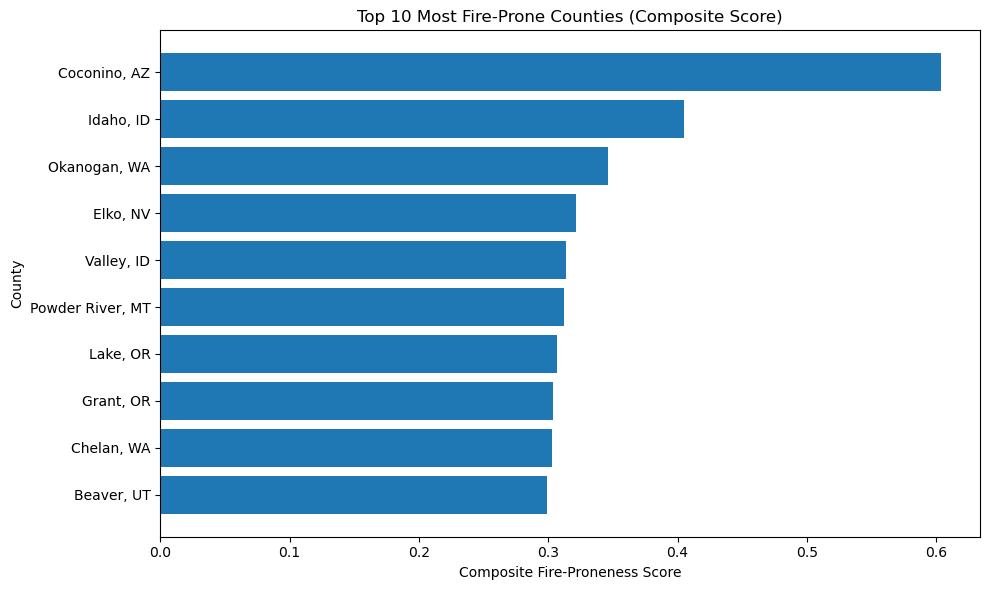

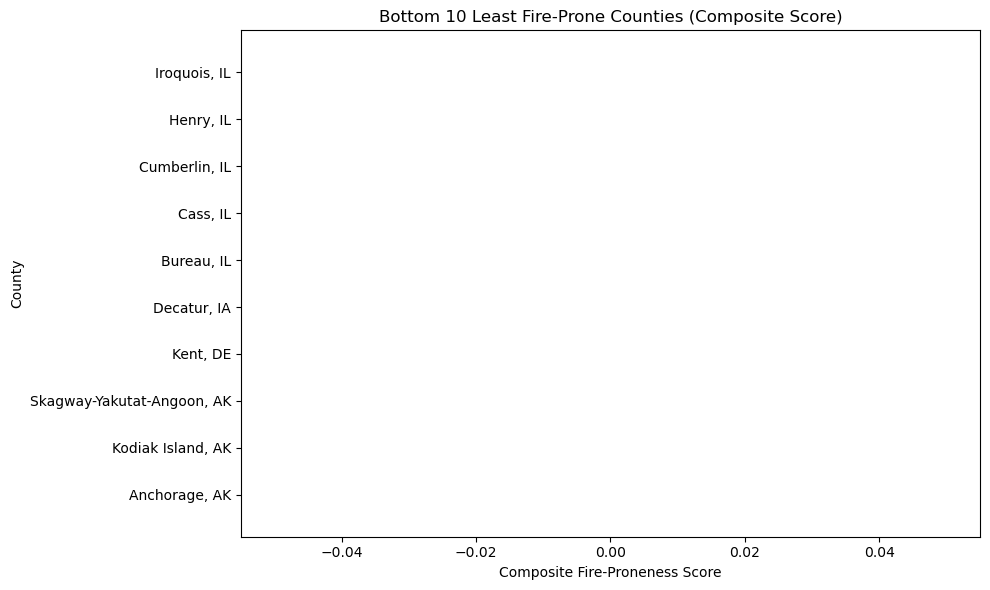

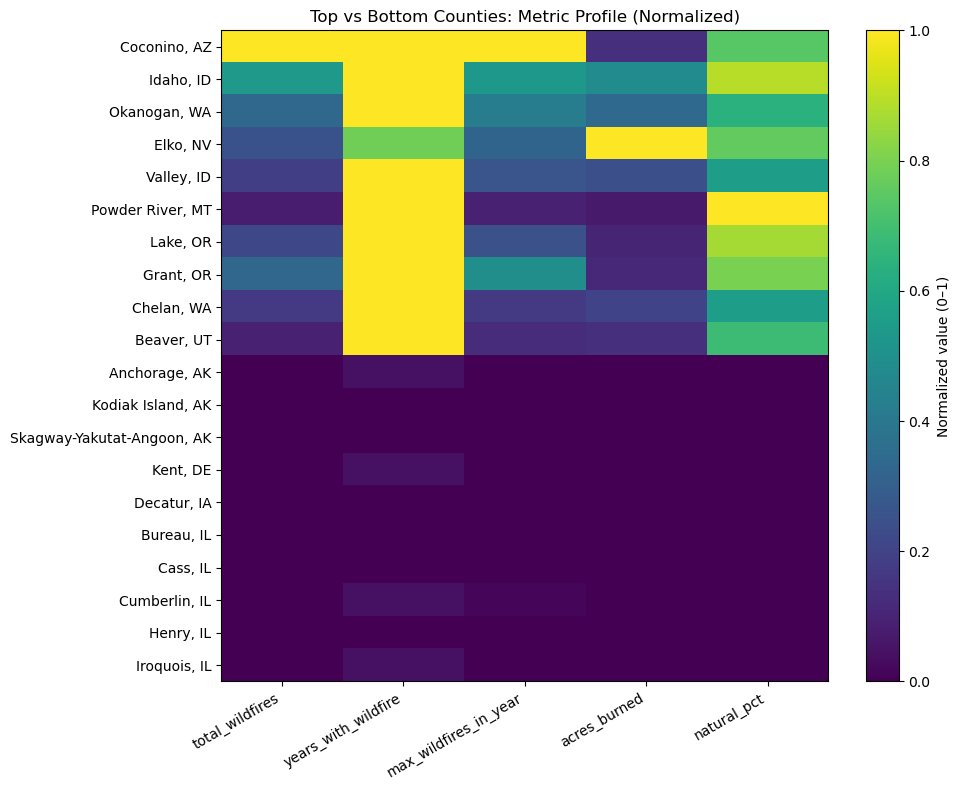

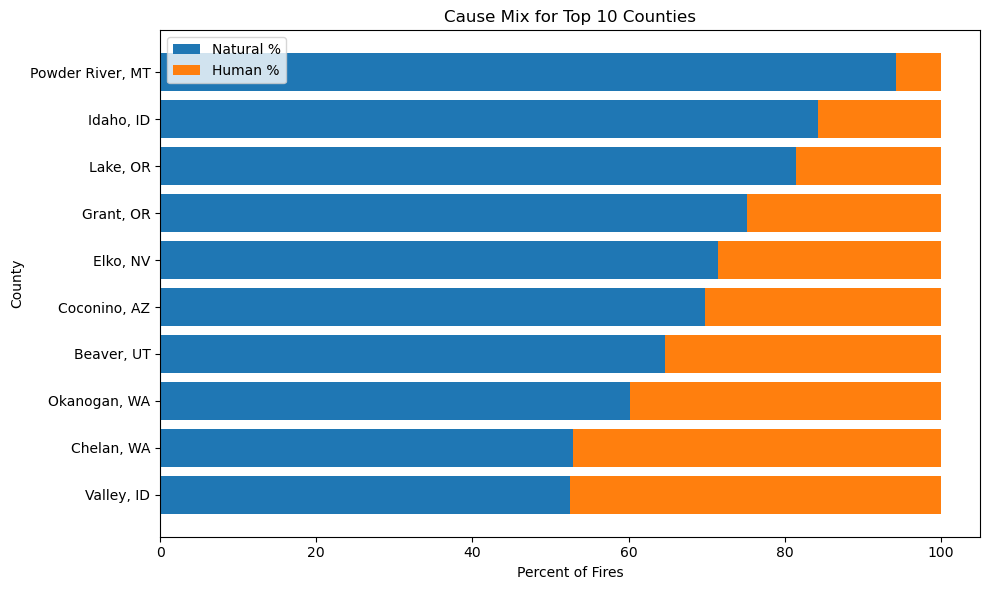

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Assumes you already have:
# df_top10, df_bottom10
# with columns like:
# county_name, STATE, composite_score, total_wildfires, years_with_wildfire,
# max_wildfires_in_year, acres_burned, natural_pct

# ---------- Prep ----------
top = df_top10.copy()
bot = df_bottom10.copy()

top["county_label"] = top["county_name"].fillna("Unknown") + ", " + top["STATE"].fillna("")
bot["county_label"] = bot["county_name"].fillna("Unknown") + ", " + bot["STATE"].fillna("")

# ---------- 1) Horizontal bar: Top 10 composite ----------
top_plot = top.sort_values("composite_score", ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(top_plot["county_label"], top_plot["composite_score"])
plt.xlabel("Composite Fire-Proneness Score")
plt.ylabel("County")
plt.title("Top 10 Most Fire-Prone Counties (Composite Score)")
plt.tight_layout()
plt.show()

# ---------- 2) Horizontal bar: Bottom 10 composite ----------
bot_plot = bot.sort_values("composite_score", ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(bot_plot["county_label"], bot_plot["composite_score"])
plt.xlabel("Composite Fire-Proneness Score")
plt.ylabel("County")
plt.title("Bottom 10 Least Fire-Prone Counties (Composite Score)")
plt.tight_layout()
plt.show()

# ---------- 3) Component comparison heatmap (Top + Bottom) ----------
metrics = [
    "total_wildfires",
    "years_with_wildfire",
    "max_wildfires_in_year",
    "acres_burned",
    "natural_pct"
]

compare = pd.concat(
    [
        top.assign(group="Top 10"),
        bot.assign(group="Bottom 10")
    ],
    ignore_index=True
)

# Keep readable order: top scores descending, then bottom ascending
compare = pd.concat(
    [
        top.sort_values("composite_score", ascending=False),
        bot.sort_values("composite_score", ascending=True)
    ],
    ignore_index=True
)
compare["county_label"] = compare["county_name"].fillna("Unknown") + ", " + compare["STATE"].fillna("")

# Min-max normalize each metric so they can be compared on same scale
norm = compare[metrics].copy().astype(float)
for c in metrics:
    cmin, cmax = norm[c].min(), norm[c].max()
    if cmax == cmin:
        norm[c] = 0.0
    else:
        norm[c] = (norm[c] - cmin) / (cmax - cmin)

heat = norm.values

plt.figure(figsize=(10, 8))
img = plt.imshow(heat, aspect="auto")
plt.colorbar(img, label="Normalized value (0–1)")
plt.xticks(range(len(metrics)), metrics, rotation=30, ha="right")
plt.yticks(range(len(compare)), compare["county_label"])
plt.title("Top vs Bottom Counties: Metric Profile (Normalized)")
plt.tight_layout()
plt.show()

# ---------- 4) (Optional) Cause mix stacked bars for Top 10 ----------
# (This is where a pie chart is less useful than side-by-side bars.)
top_cause = top.copy()
top_cause["human_pct"] = 100 - top_cause["natural_pct"]
top_cause = top_cause.sort_values("natural_pct", ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(top_cause["county_label"], top_cause["natural_pct"], label="Natural %")
plt.barh(top_cause["county_label"], top_cause["human_pct"], left=top_cause["natural_pct"], label="Human %")
plt.xlabel("Percent of Fires")
plt.ylabel("County")
plt.title("Cause Mix for Top 10 Counties")
plt.legend()
plt.tight_layout()
plt.show()


In [15]:
with sqlite3.connect(db_path) as conn:
    df_lightning_top = pd.read_sql_query("""
    SELECT
      STATE,
      substr('00000' || TRIM(FIPS_CODE), -5, 5) AS fips5,
      COALESCE(NULLIF(TRIM(MAX(FIPS_NAME)), ''), NULLIF(TRIM(MAX(COUNTY)), '')) AS county_name,
      COUNT(*) AS lightning_fires
    FROM Fires
    WHERE FIRE_YEAR BETWEEN 1992 AND 2015
      AND STAT_CAUSE_DESCR = 'Lightning'
      AND FIPS_CODE IS NOT NULL
      AND TRIM(FIPS_CODE) <> ''
    GROUP BY STATE, fips5
    ORDER BY lightning_fires DESC
    LIMIT 25;
    """, conn)

    df_lightning_bottom = pd.read_sql_query("""
    SELECT
      STATE,
      substr('00000' || TRIM(FIPS_CODE), -5, 5) AS fips5,
      COALESCE(NULLIF(TRIM(MAX(FIPS_NAME)), ''), NULLIF(TRIM(MAX(COUNTY)), '')) AS county_name,
      COUNT(*) AS lightning_fires
    FROM Fires
    WHERE FIRE_YEAR BETWEEN 1992 AND 2015
      AND STAT_CAUSE_DESCR = 'Lightning'
      AND FIPS_CODE IS NOT NULL
      AND TRIM(FIPS_CODE) <> ''
    GROUP BY STATE, fips5
    HAVING COUNT(*) > 0
    ORDER BY lightning_fires ASC, STATE, fips5
    LIMIT 25;
    """, conn)

print(df_lightning_top)
print(df_lightning_bottom)

   STATE  fips5 county_name  lightning_fires
0     AZ  00005    Coconino             5511
1     ID  00049       Idaho             3585
2     OR  00035     Klamath             2029
3     OR  00023       Grant             1951
4     NV  00017     Lincoln             1884
5     CO  00103  Rio Blanco             1757
6     AZ  00015      Mohave             1658
7     OR  00019     Douglas             1607
8     UT  00037    San Juan             1605
9     WA  00047    Okanogan             1597
10    FL  00127     Volusia             1558
11    CO  00081      Moffat             1495
12    NM  00039  Rio Arriba             1459
13    OR  00017   Deschutes             1435
14    NV  00007        Elko             1423
15    OR  00037        Lake             1390
16    OR  00029     Jackson             1299
17    CA  00093    Siskiyou             1267
18    NV  00033  White Pine             1267
19    MT  00063    Missoula             1137
20    NM  00003      Catron             1048
21    AZ  

In [16]:
with sqlite3.connect(db_path) as conn:
    df_human_top = pd.read_sql_query("""
    SELECT
      STATE,
      substr('00000' || TRIM(FIPS_CODE), -5, 5) AS fips5,
      COALESCE(NULLIF(TRIM(MAX(FIPS_NAME)), ''), NULLIF(TRIM(MAX(COUNTY)), '')) AS county_name,
      COUNT(*) AS human_fires
    FROM Fires
    WHERE FIRE_YEAR BETWEEN 1992 AND 2015
      AND (STAT_CAUSE_DESCR IS NULL OR STAT_CAUSE_DESCR <> 'Lightning')
      AND FIPS_CODE IS NOT NULL
      AND TRIM(FIPS_CODE) <> ''
    GROUP BY STATE, fips5
    ORDER BY human_fires DESC
    LIMIT 25;
    """, conn)

    df_human_bottom = pd.read_sql_query("""
    SELECT
      STATE,
      substr('00000' || TRIM(FIPS_CODE), -5, 5) AS fips5,
      COALESCE(NULLIF(TRIM(MAX(FIPS_NAME)), ''), NULLIF(TRIM(MAX(COUNTY)), '')) AS county_name,
      COUNT(*) AS human_fires
    FROM Fires
    WHERE FIRE_YEAR BETWEEN 1992 AND 2015
      AND (STAT_CAUSE_DESCR IS NULL OR STAT_CAUSE_DESCR <> 'Lightning')
      AND FIPS_CODE IS NOT NULL
      AND TRIM(FIPS_CODE) <> ''
    GROUP BY STATE, fips5
    HAVING COUNT(*) > 0
    ORDER BY human_fires ASC, STATE, fips5
    LIMIT 25;
    """, conn)

print(df_human_top)
print(df_human_bottom)

   STATE  fips5   county_name  human_fires
0     NY  00103       Suffolk         7190
1     HI  00003      Honolulu         6780
2     CA  00065     Riverside         6696
3     NJ  00029         Ocean         4921
4     OK  00089     McCurtain         4492
5     GA  00175       Laurens         4053
6     MN  00137     St. Louis         3939
7     SC  00089  Williamsburg         3713
8     SC  00015      Berkeley         3571
9     NY  00071        Orange         3552
10    NY  00055        Monroe         3521
11    FL  00105          Polk         3332
12    NJ  00001      Atlantic         3209
13    OK  00127    Pushmataha         3048
14    TX  00423         Smith         3039
15    AL  00097        Mobile         3007
16    FL  00113    Santa Rosa         2906
17    NY  00059        Nassau         2854
18    NY  00087      Rockland         2819
19    SC  00075    Orangeburg         2688
20    TX  00401          Rusk         2688
21    OK  00001         Adair         2669
22    TX  0

How often do fires happen each year?

In [17]:
with sqlite3.connect(db_path) as conn:
    q_year_county = """
    SELECT
      FIRE_YEAR,
      STATE,
      substr('00000' || TRIM(FIPS_CODE), -5, 5) AS fips5,
      COALESCE(NULLIF(TRIM(MAX(FIPS_NAME)), ''), NULLIF(TRIM(MAX(COUNTY)), '')) AS county_name,
      COUNT(*) AS n_fires
    FROM Fires
    WHERE FIRE_YEAR BETWEEN 1992 AND 2015
      AND FIPS_CODE IS NOT NULL
      AND TRIM(FIPS_CODE) <> ''
    GROUP BY FIRE_YEAR, STATE, fips5
    ORDER BY FIRE_YEAR, n_fires DESC;
    """
    df_year_county = pd.read_sql_query(q_year_county, conn)

df_year_county.head(20)


,FIRE_YEAR,STATE,fips5,county_name,n_fires
0,1992,SC,00015,Berkeley,393
1,1992,SC,00089,Williamsburg,355
2,1992,NJ,00029,Ocean,330
3,1992,MS,00073,Lamar,285
4,1992,SC,00027,Clarendon,278
5,1992,SC,00029,Colleton,261
6,1992,SC,00063,Lexington,245
7,1992,FL,00105,Polk,234
8,1992,OK,00041,Delaware,222
9,1992,OR,00035,Klamath,206


In [18]:
with sqlite3.connect(db_path) as conn:
    q_county_profile = """
    WITH base AS (
      SELECT
        FIRE_YEAR,
        STATE,
        substr('00000' || TRIM(FIPS_CODE), -5, 5) AS fips5,
        COALESCE(NULLIF(TRIM(FIPS_NAME), ''), NULLIF(TRIM(COUNTY), '')) AS county_name,
        STAT_CAUSE_DESCR,
        COALESCE(FIRE_SIZE, 0.0) AS fire_size,
        LATITUDE,
        LONGITUDE
      FROM Fires
      WHERE FIRE_YEAR BETWEEN 1992 AND 2015
        AND FIPS_CODE IS NOT NULL
        AND TRIM(FIPS_CODE) <> ''
    ),

    county_totals AS (
      SELECT
        STATE,
        fips5,
        MAX(county_name) AS county_name,
        COUNT(*) AS total_fires,
        SUM(CASE WHEN STAT_CAUSE_DESCR = 'Lightning' THEN 1 ELSE 0 END) AS natural_fires,
        SUM(CASE WHEN STAT_CAUSE_DESCR IS NULL OR STAT_CAUSE_DESCR <> 'Lightning' THEN 1 ELSE 0 END) AS human_fires,
        ROUND(SUM(fire_size), 2) AS acres_burned,
        ROUND(AVG(fire_size), 2) AS avg_fire_size_acres,
        MIN(FIRE_YEAR) AS first_year_seen,
        MAX(FIRE_YEAR) AS last_year_seen
      FROM base
      GROUP BY STATE, fips5
    ),

    county_year AS (
      SELECT
        STATE,
        fips5,
        FIRE_YEAR,
        COUNT(*) AS fires_in_year
      FROM base
      GROUP BY STATE, fips5, FIRE_YEAR
    ),

    -- Linear trend slope of annual fire counts by county:
    -- slope = (n*sum(xy)-sum(x)sum(y)) / (n*sum(xx)-sum(x)^2)
    county_trend AS (
      SELECT
        STATE,
        fips5,
        COUNT(*) AS n_years_with_data,
        ROUND(
          (
            COUNT(*) * SUM(FIRE_YEAR * fires_in_year) - SUM(FIRE_YEAR) * SUM(fires_in_year)
          ) * 1.0
          /
          NULLIF(
            COUNT(*) * SUM(FIRE_YEAR * FIRE_YEAR) - SUM(FIRE_YEAR) * SUM(FIRE_YEAR),
            0
          ),
          6
        ) AS yearly_fire_count_slope
      FROM county_year
      GROUP BY STATE, fips5
    ),

    county_geo AS (
      SELECT
        STATE,
        fips5,
        ROUND(MIN(LATITUDE), 5)  AS min_lat,
        ROUND(MAX(LATITUDE), 5)  AS max_lat,
        ROUND(MIN(LONGITUDE), 5) AS min_lon,
        ROUND(MAX(LONGITUDE), 5) AS max_lon,
        ROUND(AVG(LATITUDE), 5)  AS centroid_lat,
        ROUND(AVG(LONGITUDE), 5) AS centroid_lon
      FROM base
      WHERE LATITUDE IS NOT NULL AND LONGITUDE IS NOT NULL
      GROUP BY STATE, fips5
    )

    SELECT
      t.STATE,
      t.fips5 AS fips_code,
      t.county_name,

      -- (1) How often fires occur
      t.total_fires,

      -- (2) Natural vs human
      t.natural_fires,
      t.human_fires,
      ROUND(100.0 * t.natural_fires / NULLIF(t.total_fires, 0), 2) AS pct_natural,
      ROUND(100.0 * t.human_fires   / NULLIF(t.total_fires, 0), 2) AS pct_human,

      -- (3) Acres affected
      t.acres_burned,
      t.avg_fire_size_acres,

      -- (4) People affected (not in this DB)
      NULL AS people_affected,

      -- (5) Trend over time
      tr.n_years_with_data,
      tr.yearly_fire_count_slope,

      -- (6) Where in county fires started (approx footprint)
      g.min_lat, g.max_lat, g.min_lon, g.max_lon,
      g.centroid_lat, g.centroid_lon,

      t.first_year_seen,
      t.last_year_seen
    FROM county_totals t
    LEFT JOIN county_trend tr
      ON t.STATE = tr.STATE AND t.fips5 = tr.fips5
    LEFT JOIN county_geo g
      ON t.STATE = g.STATE AND t.fips5 = g.fips5
    ORDER BY t.total_fires DESC;
    """

    df_county_profile = pd.read_sql_query(q_county_profile, conn)

df_county_profile


,STATE,fips_code,county_name,total_fires,natural_fires,human_fires,pct_natural,pct_human,acres_burned,avg_fire_size_acres,...,n_years_with_data,yearly_fire_count_slope,min_lat,max_lat,min_lon,max_lon,centroid_lat,centroid_lon,first_year_seen,last_year_seen
0,AZ,00005,Coconino,7900,5511,2389,69.76,30.24,423736.78,53.64,...,24,13.090435,31.44170,36.99990,-113.69890,-109.41111,35.14191,-111.60186,1992,2015
1,NY,00103,Suffolk,7595,405,7190,5.33,94.67,12568.83,1.65,...,23,25.574699,40.61623,43.27290,-74.40560,-71.87384,40.83783,-73.01515,1992,2015
2,CA,00065,Riverside,6925,229,6696,3.31,96.69,223185.63,32.23,...,18,32.207430,32.80944,35.75520,-117.84861,-114.49908,33.76489,-116.82425,1998,2015
3,HI,00003,Honolulu,6780,0,6780,0.00,100.00,47110.79,6.95,...,19,11.734462,21.25573,21.70732,-158.27393,-157.65666,21.41510,-158.03765,1992,2015
4,NJ,00029,Ocean,4941,20,4921,0.40,99.60,45765.44,9.26,...,24,-8.721304,39.32083,41.16380,-75.37500,-73.99153,39.95495,-74.23431,1992,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2790,WI,00065,Lafayette,1,0,1,0.00,100.00,60.00,60.00,...,1,NaN,42.79376,42.79376,-89.99838,-89.99838,42.79376,-89.99838,1999,1999
2791,WI,00079,Milwaukee,1,0,1,0.00,100.00,3.50,3.50,...,1,NaN,43.13113,43.13113,-87.97809,-87.97809,43.13113,-87.97809,2014,2014
2792,WI,00089,Ozaukee,1,0,1,0.00,100.00,0.17,0.17,...,1,NaN,43.45768,43.45768,-87.82292,-87.82292,43.45768,-87.82292,1995,1995
2793,WI,00091,Pepin,1,0,1,0.00,100.00,54.00,54.00,...,1,NaN,44.67302,44.67302,-91.69889,-91.69889,44.67302,-91.69889,2009,2009


okay, i want to know the following about counties: 
1) How often do fires occur 
2) are thy man made or natural (percentage)
3) how many acres were affected 4) how many people were affected 5) if there's a trend of fires over times for that county 6) where in the county the fire started. connect this as one sqlite python query

In [19]:
with sqlite3.connect(db_path) as conn:
    q_fire_prone_index = """
    WITH base AS (
      SELECT
        FIRE_YEAR,
        STATE,
        substr('00000' || TRIM(FIPS_CODE), -5, 5) AS fips5,
        COALESCE(NULLIF(TRIM(FIPS_NAME), ''), NULLIF(TRIM(COUNTY), '')) AS county_name,
        COALESCE(FIRE_SIZE, 0.0) AS fire_size,
        STAT_CAUSE_DESCR
      FROM Fires
      WHERE FIRE_YEAR BETWEEN 1992 AND 2015
        AND FIPS_CODE IS NOT NULL
        AND TRIM(FIPS_CODE) <> ''
    ),

    county_totals AS (
      SELECT
        STATE,
        fips5,
        MAX(county_name) AS county_name,
        COUNT(*) AS total_fires,
        SUM(fire_size) AS total_acres,
        AVG(fire_size) AS avg_acres_per_fire,
        SUM(CASE WHEN fire_size >= 1000 THEN 1 ELSE 0 END) AS large_fire_count,
        SUM(CASE WHEN STAT_CAUSE_DESCR = 'Lightning' THEN 1 ELSE 0 END) AS lightning_count
      FROM base
      GROUP BY STATE, fips5
    ),

    county_year AS (
      SELECT
        STATE,
        fips5,
        FIRE_YEAR,
        COUNT(*) AS fires_in_year
      FROM base
      GROUP BY STATE, fips5, FIRE_YEAR
    ),

    county_persistence AS (
      SELECT
        STATE,
        fips5,
        COUNT(*) AS years_with_fire
      FROM county_year
      GROUP BY STATE, fips5
    ),

    county_trend AS (
      -- slope of annual fire counts by county
      SELECT
        STATE,
        fips5,
        COUNT(*) AS n_years_points,
        (
          (COUNT(*) * SUM(FIRE_YEAR * fires_in_year) - SUM(FIRE_YEAR) * SUM(fires_in_year)) * 1.0
          /
          NULLIF(
            COUNT(*) * SUM(FIRE_YEAR * FIRE_YEAR) - SUM(FIRE_YEAR) * SUM(FIRE_YEAR),
            0
          )
        ) AS trend_slope
      FROM county_year
      GROUP BY STATE, fips5
    ),

    metrics AS (
      SELECT
        t.STATE,
        t.fips5,
        t.county_name,

        t.total_fires,
        t.total_acres,
        t.avg_acres_per_fire,

        1.0 * t.large_fire_count / NULLIF(t.total_fires, 0) AS large_fire_share,
        1.0 * t.lightning_count / NULLIF(t.total_fires, 0) AS lightning_share,

        -- 24-year window: 1992-2015
        1.0 * t.total_fires / 24.0 AS fires_per_year,
        1.0 * p.years_with_fire / 24.0 AS persistence_share,

        COALESCE(tr.trend_slope, 0.0) AS trend_slope
      FROM county_totals t
      LEFT JOIN county_persistence p
        ON t.STATE = p.STATE AND t.fips5 = p.fips5
      LEFT JOIN county_trend tr
        ON t.STATE = tr.STATE AND t.fips5 = tr.fips5
      WHERE t.total_fires >= 10  -- stability filter (adjust as needed)
    ),

    bounds AS (
      SELECT
        MIN(fires_per_year) AS min_fpy, MAX(fires_per_year) AS max_fpy,
        MIN(avg_acres_per_fire) AS min_aaf, MAX(avg_acres_per_fire) AS max_aaf,
        MIN(large_fire_share) AS min_lfs, MAX(large_fire_share) AS max_lfs,
        MIN(persistence_share) AS min_ps, MAX(persistence_share) AS max_ps,
        MIN(trend_slope) AS min_ts, MAX(trend_slope) AS max_ts,
        MIN(lightning_share) AS min_ls, MAX(lightning_share) AS max_ls
      FROM metrics
    ),

    scored AS (
      SELECT
        m.*,

        -- Min-max scaled components [0,1]
        (m.fires_per_year - b.min_fpy) / NULLIF(b.max_fpy - b.min_fpy, 0) AS s_freq,
        (m.avg_acres_per_fire - b.min_aaf) / NULLIF(b.max_aaf - b.min_aaf, 0) AS s_severity,
        (m.large_fire_share - b.min_lfs) / NULLIF(b.max_lfs - b.min_lfs, 0) AS s_large,
        (m.persistence_share - b.min_ps) / NULLIF(b.max_ps - b.min_ps, 0) AS s_persist,
        (m.trend_slope - b.min_ts) / NULLIF(b.max_ts - b.min_ts, 0) AS s_trend,
        (m.lightning_share - b.min_ls) / NULLIF(b.max_ls - b.min_ls, 0) AS s_lightning
      FROM metrics m
      CROSS JOIN bounds b
    )

    SELECT
      STATE,
      fips5 AS fips_code,
      county_name,

      total_fires,
      ROUND(total_acres, 2) AS total_acres,
      ROUND(avg_acres_per_fire, 2) AS avg_acres_per_fire,
      ROUND(large_fire_share * 100.0, 2) AS large_fire_pct,
      ROUND(lightning_share * 100.0, 2) AS lightning_pct,
      ROUND(fires_per_year, 3) AS fires_per_year,
      ROUND(persistence_share * 100.0, 2) AS persistence_pct_years_with_fire,
      ROUND(trend_slope, 4) AS trend_slope,

      -- Composite score (weights you can tune)
      ROUND(
        0.35 * s_freq +
        0.20 * s_severity +
        0.15 * s_large +
        0.15 * s_persist +
        0.10 * s_trend +
        0.05 * s_lightning
      , 4) AS fire_prone_score
    FROM scored
    ORDER BY fire_prone_score DESC;
    """

    df_fire_prone = pd.read_sql_query(q_fire_prone_index, conn)

# Most fire-prone (top 20)
df_most = df_fire_prone.head(20)

# Least fire-prone among included counties (bottom 20)
df_least = df_fire_prone.tail(20)

print("Most fire-prone:")
print(df_most)

print("\nLeast fire-prone:")
print(df_least)


Most fire-prone:
   STATE fips_code    county_name  total_fires  total_acres  \
0     AZ     00005       Coconino         7900    423736.78   
1     NY     00103        Suffolk         7595     12568.83   
2     CA     00065      Riverside         6925    223185.63   
3     HI     00003       Honolulu         6780     47110.79   
4     ID     00049          Idaho         4255   1509590.25   
5     AK     00290  Yukon-Koyukuk           51   1754427.69   
6     NJ     00029          Ocean         4941     45765.44   
7     OR     00035        Klamath         3559     86404.67   
8     MN     00137      St. Louis         4153     21489.09   
9     OR     00019        Douglas         3542    211922.68   
10    FL     00105           Polk         4013    143854.90   
11    OR     00029        Jackson         3675     62621.30   
12    OK     00089      McCurtain         4593     60765.71   
13    GA     00175        Laurens         4246      9762.60   
14    NY     00071         Orange     

In [20]:
import sqlite3
import pandas as pd

db_path = "/Users/alexdubro/.cache/kagglehub/datasets/rtatman/188-million-us-wildfires/versions/2/FPA_FOD_20170508.sqlite"

with sqlite3.connect(db_path) as conn:
    q_county_metrics = """
    WITH base AS (
      SELECT
        FIRE_YEAR,
        STATE,
        substr('00000' || TRIM(FIPS_CODE), -5, 5) AS fips5,
        COALESCE(NULLIF(TRIM(FIPS_NAME), ''), NULLIF(TRIM(COUNTY), '')) AS county_name,
        COALESCE(FIRE_SIZE, 0.0) AS fire_size,
        STAT_CAUSE_DESCR
      FROM Fires
      WHERE FIRE_YEAR BETWEEN 1992 AND 2015
        AND FIPS_CODE IS NOT NULL
        AND TRIM(FIPS_CODE) <> ''
    ),

    -- Metric A/B/C totals by county
    county_totals AS (
      SELECT
        STATE,
        fips5,
        MAX(county_name) AS county_name,
        COUNT(*) AS total_fires,                                       -- Metric A
        SUM(fire_size) AS total_acres_burned,                          -- Metric B
        AVG(fire_size) AS avg_acres_per_fire,                          -- Metric B
        SUM(CASE WHEN fire_size >= 1000 THEN 1 ELSE 0 END) AS large_fire_count, -- Metric B
        SUM(CASE WHEN STAT_CAUSE_DESCR = 'Lightning' THEN 1 ELSE 0 END) AS lightning_count -- Metric C
      FROM base
      GROUP BY STATE, fips5
    ),

    -- yearly counts for trend + persistence
    county_year AS (
      SELECT
        STATE,
        fips5,
        FIRE_YEAR,
        COUNT(*) AS fires_in_year
      FROM base
      GROUP BY STATE, fips5, FIRE_YEAR
    ),

    -- Metric D: years with at least one fire / 24
    county_persistence AS (
      SELECT
        STATE,
        fips5,
        COUNT(*) AS years_with_fire
      FROM county_year
      GROUP BY STATE, fips5
    ),

    -- Metric E: linear slope of annual fire counts by county
    county_trend AS (
      SELECT
        STATE,
        fips5,
        COUNT(*) AS n_points,
        (
          (COUNT(*) * SUM(FIRE_YEAR * fires_in_year) - SUM(FIRE_YEAR) * SUM(fires_in_year)) * 1.0
          /
          NULLIF(
            COUNT(*) * SUM(FIRE_YEAR * FIRE_YEAR) - SUM(FIRE_YEAR) * SUM(FIRE_YEAR),
            0
          )
        ) AS trend_slope
      FROM county_year
      GROUP BY STATE, fips5
    )

    SELECT
      t.STATE,
      t.fips5 AS fips_code,
      t.county_name,

      -- Metric A: Frequency
      t.total_fires,
      ROUND(1.0 * t.total_fires / 24.0, 3) AS fires_per_year,

      -- Metric B: Severity
      ROUND(t.total_acres_burned, 2) AS total_acres_burned,
      ROUND(t.avg_acres_per_fire, 2) AS avg_acres_per_fire,
      ROUND(100.0 * t.large_fire_count / NULLIF(t.total_fires, 0), 2) AS large_fire_rate_pct,

      -- Metric C: Cause mix
      ROUND(100.0 * t.lightning_count / NULLIF(t.total_fires, 0), 2) AS lightning_share_pct,
      ROUND(100.0 * (t.total_fires - t.lightning_count) / NULLIF(t.total_fires, 0), 2) AS human_share_pct,

      -- Metric D: Persistence
      p.years_with_fire,
      ROUND(100.0 * p.years_with_fire / 24.0, 2) AS persistence_pct_years_with_fire,

      -- Metric E: Trend
      ROUND(COALESCE(tr.trend_slope, 0.0), 4) AS trend_slope_annual_fire_count

    FROM county_totals t
    LEFT JOIN county_persistence p
      ON t.STATE = p.STATE AND t.fips5 = p.fips5
    LEFT JOIN county_trend tr
      ON t.STATE = tr.STATE AND t.fips5 = tr.fips5
    ORDER BY t.total_fires DESC;
    """

    df_county_metrics = pd.read_sql_query(q_county_metrics, conn)

print(df_county_metrics.head(20))


   STATE fips_code   county_name  total_fires  fires_per_year  \
0     AZ     00005      Coconino         7900         329.167   
1     NY     00103       Suffolk         7595         316.458   
2     CA     00065     Riverside         6925         288.542   
3     HI     00003      Honolulu         6780         282.500   
4     NJ     00029         Ocean         4941         205.875   
5     OK     00089     McCurtain         4593         191.375   
6     ID     00049         Idaho         4255         177.292   
7     GA     00175       Laurens         4246         176.917   
8     MN     00137     St. Louis         4153         173.042   
9     FL     00105          Polk         4013         167.208   
10    NY     00055        Monroe         3747         156.125   
11    SC     00089  Williamsburg         3732         155.500   
12    NY     00071        Orange         3694         153.917   
13    OR     00029       Jackson         3675         153.125   
14    SC     00015      B

In [21]:
import sqlite3
import pandas as pd

db_path = "/Users/alexdubro/.cache/kagglehub/datasets/rtatman/188-million-us-wildfires/versions/2/FPA_FOD_20170508.sqlite"

with sqlite3.connect(db_path) as conn:
    q_most_fire_prone = """
    WITH base AS (
      SELECT
        FIRE_YEAR,
        STATE,
        substr('00000' || TRIM(FIPS_CODE), -5, 5) AS fips5,
        COALESCE(NULLIF(TRIM(FIPS_NAME), ''), NULLIF(TRIM(COUNTY), '')) AS county_name,
        COALESCE(FIRE_SIZE, 0.0) AS fire_size,
        STAT_CAUSE_DESCR
      FROM Fires
      WHERE FIRE_YEAR BETWEEN 1992 AND 2015
        AND FIPS_CODE IS NOT NULL
        AND TRIM(FIPS_CODE) <> ''
    ),

    county_totals AS (
      SELECT
        STATE,
        fips5,
        MAX(county_name) AS county_name,
        COUNT(*) AS total_fires,
        SUM(fire_size) AS total_acres_burned,
        SUM(CASE WHEN STAT_CAUSE_DESCR = 'Lightning' THEN 1 ELSE 0 END) AS natural_fires
      FROM base
      GROUP BY STATE, fips5
    ),

    county_year AS (
      SELECT
        STATE,
        fips5,
        FIRE_YEAR,
        COUNT(*) AS fires_in_year
      FROM base
      GROUP BY STATE, fips5, FIRE_YEAR
    ),

    county_persistence AS (
      SELECT
        STATE,
        fips5,
        COUNT(*) AS years_with_fire,
        MIN(fires_in_year) AS min_fires_in_any_year
      FROM county_year
      GROUP BY STATE, fips5
    ),

    filtered AS (
      SELECT
        t.STATE,
        t.fips5 AS fips_code,
        t.county_name,
        t.total_fires,
        ROUND(t.total_acres_burned, 2) AS total_acres_burned,
        t.natural_fires,
        ROUND(100.0 * t.natural_fires / NULLIF(t.total_fires, 0), 2) AS natural_share_pct,
        ROUND(100.0 * (t.total_fires - t.natural_fires) / NULLIF(t.total_fires, 0), 2) AS human_share_pct,
        p.years_with_fire,
        p.min_fires_in_any_year
      FROM county_totals t
      JOIN county_persistence p
        ON t.STATE = p.STATE AND t.fips5 = p.fips5
      WHERE p.years_with_fire = 24      -- at least one fire every year (1992-2015)
        AND p.min_fires_in_any_year >= 1
    )

    SELECT *
    FROM filtered
    ORDER BY
      total_fires DESC,         -- most fires
      total_acres_burned DESC,  -- most acres burned
      natural_share_pct DESC;   -- greatest natural share
    """

    df_most_fire_prone = pd.read_sql_query(q_most_fire_prone, conn)

print(df_most_fire_prone.head(25))
print(f"\nCount of counties meeting your strict criteria: {len(df_most_fire_prone)}")


   STATE fips_code county_name  total_fires  total_acres_burned  \
0     AZ     00005    Coconino         7900           423736.78   
1     NJ     00029       Ocean         4941            45765.44   
2     ID     00049       Idaho         4255          1509590.25   
3     MN     00137   St. Louis         4153            21489.09   
4     FL     00105        Polk         4013           143854.90   
5     NY     00071      Orange         3694             5820.63   
6     OR     00029     Jackson         3675            62621.30   
7     OR     00035     Klamath         3559            86404.67   
8     OR     00019     Douglas         3542           211922.68   
9     FL     00127     Volusia         3404           146732.50   
10    OR     00017   Deschutes         3260            73120.76   
11    NJ     00001    Atlantic         3237             4889.95   
12    TX     00423       Smith         3106            19054.54   
13    FL     00113  Santa Rosa         3023            50274.2

In [22]:
import sqlite3
import pandas as pd

db_path = "/Users/alexdubro/.cache/kagglehub/datasets/rtatman/188-million-us-wildfires/versions/2/FPA_FOD_20170508.sqlite"

with sqlite3.connect(db_path) as conn:
    q_ranked_counties = """
    WITH base AS (
      SELECT
        FIRE_YEAR,
        STATE,
        substr('00000' || TRIM(FIPS_CODE), -5, 5) AS fips5,
        COALESCE(NULLIF(TRIM(FIPS_NAME), ''), NULLIF(TRIM(COUNTY), '')) AS county_name,
        COALESCE(FIRE_SIZE, 0.0) AS fire_size,
        STAT_CAUSE_DESCR
      FROM Fires
      WHERE FIRE_YEAR BETWEEN 1992 AND 2015
        AND FIPS_CODE IS NOT NULL
        AND TRIM(FIPS_CODE) <> ''
    ),

    county_year AS (
      SELECT
        STATE,
        fips5,
        FIRE_YEAR,
        COUNT(*) AS fires_in_year,
        SUM(fire_size) AS acres_in_year
      FROM base
      GROUP BY STATE, fips5, FIRE_YEAR
    ),

    county_rollup AS (
      SELECT
        b.STATE,
        b.fips5,
        MAX(b.county_name) AS county_name,
        COUNT(*) AS total_fires,
        SUM(b.fire_size) AS total_acres,
        SUM(CASE WHEN b.STAT_CAUSE_DESCR = 'Lightning' THEN 1 ELSE 0 END) AS natural_fires
      FROM base b
      GROUP BY b.STATE, b.fips5
    ),

    county_persistence AS (
      SELECT
        STATE,
        fips5,
        COUNT(*) AS years_with_fire,        -- number of distinct years with >=1 fire
        MIN(fires_in_year) AS min_fires_any_year,
        MAX(fires_in_year) AS max_fires_any_year,
        AVG(fires_in_year) AS avg_fires_per_active_year
      FROM county_year
      GROUP BY STATE, fips5
    ),

    eligible AS (
      SELECT
        r.STATE,
        r.fips5 AS fips_code,
        r.county_name,
        r.total_fires,
        ROUND(r.total_acres, 2) AS total_acres,
        ROUND(100.0 * r.natural_fires / NULLIF(r.total_fires, 0), 2) AS natural_pct,
        p.years_with_fire,
        p.min_fires_any_year,
        p.max_fires_any_year,
        ROUND(p.avg_fires_per_active_year, 2) AS avg_fires_per_active_year
      FROM county_rollup r
      JOIN county_persistence p
        ON r.STATE = p.STATE AND r.fips5 = p.fips5
      WHERE p.years_with_fire = 24      -- fire in every year from 1992-2015
        AND p.min_fires_any_year >= 1
    )

    SELECT *
    FROM eligible
    ORDER BY
      total_fires DESC,   -- greatest fires
      natural_pct DESC,   -- greatest natural %
      total_acres DESC    -- greatest acres
    ;
    """

    df_ranked = pd.read_sql_query(q_ranked_counties, conn)

print("Top county by your criteria:")
print(df_ranked.head(1))
print("\nTop 25 counties by your criteria:")
print(df_ranked.head(25))


Top county by your criteria:
  STATE fips_code county_name  total_fires  total_acres  natural_pct  \
0    AZ     00005    Coconino         7900    423736.78        69.76   

   years_with_fire  min_fires_any_year  max_fires_any_year  \
0               24                  18                 673   

   avg_fires_per_active_year  
0                     329.17  

Top 25 counties by your criteria:
   STATE fips_code county_name  total_fires  total_acres  natural_pct  \
0     AZ     00005    Coconino         7900    423736.78        69.76   
1     NJ     00029       Ocean         4941     45765.44         0.40   
2     ID     00049       Idaho         4255   1509590.25        84.25   
3     MN     00137   St. Louis         4153     21489.09         5.15   
4     FL     00105        Polk         4013    143854.90        16.97   
5     NY     00071      Orange         3694      5820.63         3.84   
6     OR     00029     Jackson         3675     62621.30        35.35   
7     OR     00035  

In [23]:
import sqlite3
import pandas as pd

db_path = "/Users/alexdubro/.cache/kagglehub/datasets/rtatman/188-million-us-wildfires/versions/2/FPA_FOD_20170508.sqlite"

with sqlite3.connect(db_path) as conn:
    q_ranked_natural_first = """
    WITH base AS (
      SELECT
        FIRE_YEAR,
        STATE,
        substr('00000' || TRIM(FIPS_CODE), -5, 5) AS fips5,
        COALESCE(NULLIF(TRIM(FIPS_NAME), ''), NULLIF(TRIM(COUNTY), '')) AS county_name,
        COALESCE(FIRE_SIZE, 0.0) AS fire_size,
        STAT_CAUSE_DESCR
      FROM Fires
      WHERE FIRE_YEAR BETWEEN 1992 AND 2015
        AND FIPS_CODE IS NOT NULL
        AND TRIM(FIPS_CODE) <> ''
    ),

    county_year AS (
      SELECT
        STATE,
        fips5,
        FIRE_YEAR,
        COUNT(*) AS fires_in_year
      FROM base
      GROUP BY STATE, fips5, FIRE_YEAR
    ),

    county_persistence AS (
      SELECT
        STATE,
        fips5,
        COUNT(*) AS years_with_fire,
        MIN(fires_in_year) AS min_fires_any_year
      FROM county_year
      GROUP BY STATE, fips5
    ),

    county_rollup AS (
      SELECT
        b.STATE,
        b.fips5,
        MAX(b.county_name) AS county_name,
        COUNT(*) AS total_fires,
        SUM(CASE WHEN b.STAT_CAUSE_DESCR = 'Lightning' THEN 1 ELSE 0 END) AS natural_fires,
        SUM(COALESCE(b.fire_size, 0.0)) AS total_acres
      FROM base b
      GROUP BY b.STATE, b.fips5
    )

    SELECT
      r.STATE,
      r.fips5 AS fips_code,
      r.county_name,
      r.natural_fires,
      r.total_fires,
      ROUND(100.0 * r.natural_fires / NULLIF(r.total_fires, 0), 2) AS natural_pct,
      ROUND(r.total_acres, 2) AS total_acres,
      p.years_with_fire
    FROM county_rollup r
    JOIN county_persistence p
      ON r.STATE = p.STATE AND r.fips5 = p.fips5
    WHERE p.years_with_fire = 24       -- at least one fire every year in 1992–2015
      AND p.min_fires_any_year >= 1
    ORDER BY
      r.natural_fires DESC,            -- PRIMARY: highest natural fires
      r.total_fires DESC,              -- then highest total fires
      total_acres DESC,                -- then most acres burned
      natural_pct DESC;                -- optional tie-break
    """

    df_ranked = pd.read_sql_query(q_ranked_natural_first, conn)

print("Top county (natural-fires-first rule):")
print(df_ranked.head(1))
print("\nTop 25:")
print(df_ranked.head(25))


Top county (natural-fires-first rule):
  STATE fips_code county_name  natural_fires  total_fires  natural_pct  \
0    AZ     00005    Coconino           5511         7900        69.76   

   total_acres  years_with_fire  
0    423736.78               24  

Top 25:
   STATE fips_code county_name  natural_fires  total_fires  natural_pct  \
0     AZ     00005    Coconino           5511         7900        69.76   
1     ID     00049       Idaho           3585         4255        84.25   
2     OR     00035     Klamath           2029         3559        57.01   
3     OR     00023       Grant           1951         2596        75.15   
4     OR     00019     Douglas           1607         3542        45.37   
5     UT     00037    San Juan           1605         2145        74.83   
6     WA     00047    Okanogan           1597         2653        60.20   
7     FL     00127     Volusia           1558         3404        45.77   
8     OR     00017   Deschutes           1435         3260  

In [24]:
import sqlite3
import pandas as pd

db_path = "/Users/alexdubro/.cache/kagglehub/datasets/rtatman/188-million-us-wildfires/versions/2/FPA_FOD_20170508.sqlite"

with sqlite3.connect(db_path) as conn:
    q_ranked_natural_pct_first = """
    WITH base AS (
      SELECT
        FIRE_YEAR,
        STATE,
        substr('00000' || TRIM(FIPS_CODE), -5, 5) AS fips5,
        COALESCE(NULLIF(TRIM(FIPS_NAME), ''), NULLIF(TRIM(COUNTY), '')) AS county_name,
        COALESCE(FIRE_SIZE, 0.0) AS fire_size,
        STAT_CAUSE_DESCR
      FROM Fires
      WHERE FIRE_YEAR BETWEEN 1992 AND 2015
        AND FIPS_CODE IS NOT NULL
        AND TRIM(FIPS_CODE) <> ''
    ),

    county_year AS (
      SELECT
        STATE,
        fips5,
        FIRE_YEAR,
        COUNT(*) AS fires_in_year
      FROM base
      GROUP BY STATE, fips5, FIRE_YEAR
    ),

    county_persistence AS (
      SELECT
        STATE,
        fips5,
        COUNT(*) AS years_with_fire,
        MIN(fires_in_year) AS min_fires_any_year
      FROM county_year
      GROUP BY STATE, fips5
    ),

    county_rollup AS (
      SELECT
        b.STATE,
        b.fips5,
        MAX(b.county_name) AS county_name,
        COUNT(*) AS total_fires,
        SUM(CASE WHEN b.STAT_CAUSE_DESCR = 'Lightning' THEN 1 ELSE 0 END) AS natural_fires,
        SUM(COALESCE(b.fire_size, 0.0)) AS total_acres
      FROM base b
      GROUP BY b.STATE, b.fips5
    )

    SELECT
      r.STATE,
      r.fips5 AS fips_code,
      r.county_name,
      ROUND(100.0 * r.natural_fires / NULLIF(r.total_fires, 0), 2) AS natural_pct,
      r.total_fires,
      ROUND(r.total_acres, 2) AS total_acres,
      p.years_with_fire
    FROM county_rollup r
    JOIN county_persistence p
      ON r.STATE = p.STATE AND r.fips5 = p.fips5
    WHERE p.years_with_fire = 24
      AND p.min_fires_any_year >= 1
      AND r.total_fires > 0
    ORDER BY
      natural_pct DESC,   -- PRIMARY: highest % natural fires
      r.total_fires DESC, -- THEN most fires
      total_acres DESC,   -- THEN most acres
      p.years_with_fire DESC;
    """

    df_ranked = pd.read_sql_query(q_ranked_natural_pct_first, conn)

print(df_ranked.head(25))


   STATE fips_code   county_name  natural_pct  total_fires  total_acres  \
0     MT     00075  Powder River        94.21          605    222106.40   
1     ID     00049         Idaho        84.25         4255   1509590.25   
2     OR     00037          Lake        81.38         1708    320361.72   
3     MT     00017        Custer        81.17          223    122708.80   
4     OR     00063       Wallowa        79.86          968    241178.60   
5     OR     00013         Crook        78.82         1190     30988.40   
6     OR     00069       Wheeler        75.92          681    128874.71   
7     OR     00023         Grant        75.15         2596    361412.93   
8     UT     00037      San Juan        74.83         2145     27713.51   
9     WA     00013      Columbia        70.04          247    180231.04   
10    ID     00079      Shoshone        69.84         1409     55014.89   
11    AZ     00005      Coconino        69.76         7900    423736.78   
12    AZ     00001       

In [25]:
import sqlite3
import pandas as pd

db_path = "/Users/alexdubro/.cache/kagglehub/datasets/rtatman/188-million-us-wildfires/versions/2/FPA_FOD_20170508.sqlite"

with sqlite3.connect(db_path) as conn:
    q_ranked_natural_pct_with_peak_year = """
    WITH base AS (
      SELECT
        FIRE_YEAR,
        STATE,
        substr('00000' || TRIM(FIPS_CODE), -5, 5) AS fips5,
        COALESCE(NULLIF(TRIM(FIPS_NAME), ''), NULLIF(TRIM(COUNTY), '')) AS county_name,
        COALESCE(FIRE_SIZE, 0.0) AS fire_size,
        STAT_CAUSE_DESCR
      FROM Fires
      WHERE FIRE_YEAR BETWEEN 1992 AND 2015
        AND FIPS_CODE IS NOT NULL
        AND TRIM(FIPS_CODE) <> ''
    ),

    county_year AS (
      SELECT
        STATE,
        fips5,
        FIRE_YEAR,
        COUNT(*) AS fires_in_year
      FROM base
      GROUP BY STATE, fips5, FIRE_YEAR
    ),

    county_persistence AS (
      SELECT
        STATE,
        fips5,
        COUNT(*) AS years_with_fire,
        MIN(fires_in_year) AS min_fires_any_year,
        MAX(fires_in_year) AS max_fires_in_year   -- NEW: peak annual fire count
      FROM county_year
      GROUP BY STATE, fips5
    ),

    county_rollup AS (
      SELECT
        b.STATE,
        b.fips5,
        MAX(b.county_name) AS county_name,
        COUNT(*) AS total_fires,
        SUM(CASE WHEN b.STAT_CAUSE_DESCR = 'Lightning' THEN 1 ELSE 0 END) AS natural_fires,
        SUM(COALESCE(b.fire_size, 0.0)) AS total_acres
      FROM base b
      GROUP BY b.STATE, b.fips5
    )

    SELECT
      r.STATE,
      r.fips5 AS fips_code,
      r.county_name,
      ROUND(100.0 * r.natural_fires / NULLIF(r.total_fires, 0), 2) AS natural_pct,
      r.total_fires,
      p.max_fires_in_year,             -- NEW column
      ROUND(r.total_acres, 2) AS total_acres,
      p.years_with_fire
    FROM county_rollup r
    JOIN county_persistence p
      ON r.STATE = p.STATE AND r.fips5 = p.fips5
    WHERE p.years_with_fire = 24
      AND p.min_fires_any_year >= 1
      AND r.total_fires > 0
    ORDER BY
      natural_pct DESC,
      r.total_fires DESC,
      p.max_fires_in_year DESC,        -- optional extra tie-break using peak year
      total_acres DESC,
      p.years_with_fire DESC;
    """

    df_ranked = pd.read_sql_query(q_ranked_natural_pct_with_peak_year, conn)

print(df_ranked.head(25))


   STATE fips_code   county_name  natural_pct  total_fires  max_fires_in_year  \
0     MT     00075  Powder River        94.21          605                 62   
1     ID     00049         Idaho        84.25         4255                358   
2     OR     00037          Lake        81.38         1708                167   
3     MT     00017        Custer        81.17          223                 22   
4     OR     00063       Wallowa        79.86          968                 87   
5     OR     00013         Crook        78.82         1190                127   
6     OR     00069       Wheeler        75.92          681                 61   
7     OR     00023         Grant        75.15         2596                333   
8     UT     00037      San Juan        74.83         2145                256   
9     WA     00013      Columbia        70.04          247                 48   
10    ID     00079      Shoshone        69.84         1409                134   
11    AZ     00005      Coco

### 3. Given the size, location and date, can you predict the cause of a wildfire?

Most interestingly, we can use this data to predict the cause of a wildfire based on its size, location, and date. This could be useful for fire management and prevention.

There are two types of causes: natural and human. Natural causes are those that are caused by lightning, and human causes are those that are caused by human activity.

For size, we can use the acres burned to predict the cause.
For locations, we can use the latitude and longitude to predict the cause.
For date, we can use the date to predict the cause.

We will consider the following metrics as we build our model:
- Accuracy
- Precision
- Recall
- F1 Score
- Accuracy
- Confusion Matrix

We will use a random forest classifier to predict the cause of a wildfire.

For our random forest classifier, we will try different attempts of our hyperparameters to optimize our model. In addition, we will cross validate our model to ensure that it is not overfitting.

In [43]:
q = """
SELECT
  FIRE_YEAR,
  DISCOVERY_DOY,
  FIRE_SIZE,
  LATITUDE,
  LONGITUDE,
  STATE,
  STAT_CAUSE_DESCR
FROM Fires
WHERE FIRE_YEAR BETWEEN 1992 AND 2015
  AND FIRE_SIZE IS NOT NULL
  AND LATITUDE IS NOT NULL
  AND LONGITUDE IS NOT NULL
  AND STAT_CAUSE_DESCR IS NOT NULL
ORDER BY RANDOM()
LIMIT 200000
;
"""

with sqlite3.connect(db_path) as conn:
    df = pd.read_sql_query(q, conn)

# -----------------------------
# 2) Binary target: Lightning vs Human
# -----------------------------
df["target"] = np.where(df["STAT_CAUSE_DESCR"].eq("Lightning"), "Lightning", "Human")

# -----------------------------
# 3) Features
# -----------------------------
df["LOG_FIRE_SIZE"] = np.log1p(df["FIRE_SIZE"])

# Date-derived
df["MONTH"] = ((df["DISCOVERY_DOY"] - 1) // 30 + 1).clip(1, 12)  # rough month proxy if only DOY
df["SEASON"] = pd.cut(
    df["MONTH"],
    bins=[0, 2, 5, 8, 11, 12],
    labels=["Winter", "Spring", "Summer", "Fall", "Winter2"],
    include_lowest=True
).replace({"Winter2": "Winter"})

# Spatial bins
df["LAT_BIN"] = (df["LATITUDE"] * 2).round() / 2   # 0.5-degree bins
df["LON_BIN"] = (df["LONGITUDE"] * 2).round() / 2

# Interactions
df["SIZE_X_LAT"] = df["LOG_FIRE_SIZE"] * df["LATITUDE"]
df["SIZE_X_LON"] = df["LOG_FIRE_SIZE"] * df["LONGITUDE"]

X = df[
    [
        "FIRE_YEAR", "DISCOVERY_DOY", "MONTH", "LOG_FIRE_SIZE",
        "LATITUDE", "LONGITUDE", "LAT_BIN", "LON_BIN",
        "STATE", "COUNTY", "SEASON", "SIZE_X_LAT", "SIZE_X_LON"
    ]
]


y = df["target"]

numeric_features = ["FIRE_YEAR", "DISCOVERY_DOY", "LOG_FIRE_SIZE", "LATITUDE", "LONGITUDE"]
categorical_features = ["STATE"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# -----------------------------
# 4) Faster Random Forest
# -----------------------------
rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=20,
    min_samples_leaf=5,
    n_jobs=-1,
    max_features='sqrt',
    bootstrap=True,
    oob_score=True,
    random_state=42,
    class_weight="balanced_subsample",
    criterion="gini"   # explicit, but default anyway
)

clf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", rf)
])

# -----------------------------
# 5) Train/test and evaluate
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf.fit(X_train, y_train)
pred = clf.predict(X_test)

print("Rows used:", len(df))
print("Balanced accuracy:", round(balanced_accuracy_score(y_test, pred), 4))
print("\nClassification report:\n", classification_report(y_test, pred))
print("Confusion matrix:\n", confusion_matrix(y_test, pred))

KeyError: "['COUNTY'] not in index"

In [ ]:
# -----------------------------
# 1) Load data (include COUNTY)
# -----------------------------
q = """
SELECT
  FIRE_YEAR,
  DISCOVERY_DOY,
  FIRE_SIZE,
  LATITUDE,
  LONGITUDE,
  STATE,
  COUNTY,
  STAT_CAUSE_DESCR
FROM Fires
WHERE FIRE_YEAR BETWEEN 1992 AND 2015
  AND FIRE_SIZE IS NOT NULL
  AND LATITUDE IS NOT NULL
  AND LONGITUDE IS NOT NULL
  AND STAT_CAUSE_DESCR IS NOT NULL
ORDER BY RANDOM()
LIMIT 200000;
"""

with sqlite3.connect(db_path) as conn:
    df = pd.read_sql_query(q, conn)

# -----------------------------
# 2) Binary target: Lightning vs Human
# -----------------------------
df["target"] = np.where(df["STAT_CAUSE_DESCR"].eq("Lightning"), "Lightning", "Human")

# -----------------------------
# 3) Feature engineering
# -----------------------------
df["LOG_FIRE_SIZE"] = np.log1p(df["FIRE_SIZE"])

# Date-derived
df["MONTH"] = ((df["DISCOVERY_DOY"] - 1) // 30 + 1).clip(1, 12)

def month_to_season(m):
    if m in [12, 1, 2]:
        return "Winter"
    elif m in [3, 4, 5]:
        return "Spring"
    elif m in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

df["SEASON"] = df["MONTH"].apply(month_to_season)

# Spatial bins
df["LAT_BIN"] = (df["LATITUDE"] * 2).round() / 2   # 0.5-degree bins
df["LON_BIN"] = (df["LONGITUDE"] * 2).round() / 2

# Interactions
df["SIZE_X_LAT"] = df["LOG_FIRE_SIZE"] * df["LATITUDE"]
df["SIZE_X_LON"] = df["LOG_FIRE_SIZE"] * df["LONGITUDE"]

# Optional cleanup for categorical robustness
for c in ["STATE", "COUNTY", "SEASON", "LAT_BIN", "LON_BIN"]:
    df[c] = df[c].astype(str).str.strip()

# -----------------------------
# 4) X / y
# -----------------------------
X = df[
    [
        "FIRE_YEAR", "DISCOVERY_DOY", "MONTH", "LOG_FIRE_SIZE",
        "LATITUDE", "LONGITUDE", "SIZE_X_LAT", "SIZE_X_LON",
        "STATE", "COUNTY", "SEASON", "LAT_BIN", "LON_BIN"
    ]
]
y = df["target"]

numeric_features = [
    "FIRE_YEAR", "DISCOVERY_DOY", "MONTH", "LOG_FIRE_SIZE",
    "LATITUDE", "LONGITUDE", "SIZE_X_LAT", "SIZE_X_LON"
]
categorical_features = ["STATE", "COUNTY", "SEASON", "LAT_BIN", "LON_BIN"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# -----------------------------
# 5) Random Forest
# -----------------------------
rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=20,
    min_samples_leaf=5,
    n_jobs=-1,
    max_features="sqrt",
    bootstrap=True,
    oob_score=True,
    random_state=42,
    class_weight="balanced_subsample",
    criterion="gini"
)

clf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", rf)
])

# -----------------------------
# 6) Train / evaluate
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf.fit(X_train, y_train)
pred = clf.predict(X_test)

print("Rows used:", len(df))
print("Balanced accuracy:", round(balanced_accuracy_score(y_test, pred), 4))
print("\nClassification report:\n", classification_report(y_test, pred))
print("Confusion matrix:\n", confusion_matrix(y_test, pred))

rf_fit = clf.named_steps["model"]
print("OOB score:", round(rf_fit.oob_score_, 4))
print("OOB error:", round(1 - rf_fit.oob_score_, 4))


Rows used: 200000
Balanced accuracy: 0.8318

Classification report:
               precision    recall  f1-score   support

       Human       0.97      0.80      0.88     34115
   Lightning       0.43      0.86      0.57      5885

    accuracy                           0.81     40000
   macro avg       0.70      0.83      0.72     40000
weighted avg       0.89      0.81      0.83     40000

Confusion matrix:
 [[27269  6846]
 [  799  5086]]
OOB score: 0.8063
OOB error: 0.1937


In [ ]:
import sqlite3
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score

# -----------------------------
# 1) Load data
# -----------------------------
q = """
SELECT
  FIRE_YEAR,
  DISCOVERY_DOY,
  FIRE_SIZE,
  LATITUDE,
  LONGITUDE,
  STATE,
  STAT_CAUSE_DESCR
FROM Fires
WHERE FIRE_YEAR BETWEEN 1992 AND 2015
  AND FIRE_SIZE IS NOT NULL
  AND LATITUDE IS NOT NULL
  AND LONGITUDE IS NOT NULL
  AND STATE IS NOT NULL
  AND STAT_CAUSE_DESCR IS NOT NULL
ORDER BY RANDOM()
LIMIT 200000;
"""

with sqlite3.connect(db_path) as conn:
    df = pd.read_sql_query(q, conn)

# -----------------------------
# 2) Target: Lightning vs Human
# -----------------------------
df["target"] = np.where(df["STAT_CAUSE_DESCR"].eq("Lightning"), "Lightning", "Human")

# -----------------------------
# 3) Feature engineering
# -----------------------------
df["LOG_FIRE_SIZE"] = np.log1p(df["FIRE_SIZE"])
df["MONTH"] = ((df["DISCOVERY_DOY"] - 1) // 30 + 1).clip(1, 12)

def month_to_season(m):
    if m in [12, 1, 2]:
        return "Winter"
    elif m in [3, 4, 5]:
        return "Spring"
    elif m in [6, 7, 8]:
        return "Summer"
    return "Fall"

df["SEASON"] = df["MONTH"].apply(month_to_season)

# Cyclical day-of-year encoding (captures annual seasonality better)
angle = 2 * np.pi * (df["DISCOVERY_DOY"] / 365.0)
df["DOY_SIN"] = np.sin(angle)
df["DOY_COS"] = np.cos(angle)

# -----------------------------
# 4) X / y
# -----------------------------
X = df[
    [
        "LOG_FIRE_SIZE",
        "DISCOVERY_DOY",
        "MONTH",
        "DOY_SIN",
        "DOY_COS",
        "LATITUDE",
        "LONGITUDE",
        "STATE",
        "SEASON"
    ]
]
y = df["target"]

numeric_features = [
    "LOG_FIRE_SIZE",
    "DISCOVERY_DOY",
    "MONTH",
    "DOY_SIN",
    "DOY_COS",
    "LATITUDE",
    "LONGITUDE",
]
categorical_features = ["STATE", "SEASON"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# -----------------------------
# 5) Random Forest (typical solid defaults for tabular classification)
# -----------------------------
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=2,
    max_features="sqrt",
    bootstrap=True,
    oob_score=True,
    class_weight="balanced_subsample",
    n_jobs=-1,
    random_state=42
)

clf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", rf)
])

# -----------------------------
# 6) Train / evaluate
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

clf.fit(X_train, y_train)
pred = clf.predict(X_test)

print("Rows used:", len(df))
print("Balanced accuracy:", round(balanced_accuracy_score(y_test, pred), 4))
print("\nClassification report:\n", classification_report(y_test, pred))
print("Confusion matrix:\n", confusion_matrix(y_test, pred))

rf_fit = clf.named_steps["model"]
print("OOB score:", round(rf_fit.oob_score_, 4))
print("OOB error:", round(1 - rf_fit.oob_score_, 4))


Rows used: 200000
Balanced accuracy: 0.8588

Classification report:
               precision    recall  f1-score   support

       Human       0.96      0.92      0.94     34107
   Lightning       0.64      0.79      0.71      5893

    accuracy                           0.90     40000
   macro avg       0.80      0.86      0.83     40000
weighted avg       0.92      0.90      0.91     40000

Confusion matrix:
 [[31522  2585]
 [ 1217  4676]]
OOB score: 0.9058
OOB error: 0.0942


In [ ]:
import sqlite3
import pandas as pd
import numpy as np
from itertools import product

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    balanced_accuracy_score,
    precision_recall_fscore_support,
    accuracy_score
)

# -----------------------------
# 1) Load data once
# -----------------------------
q = """
SELECT
  FIRE_YEAR,
  DISCOVERY_DOY,
  FIRE_SIZE,
  LATITUDE,
  LONGITUDE,
  STATE,
  STAT_CAUSE_DESCR
FROM Fires
WHERE FIRE_YEAR BETWEEN 1992 AND 2015
  AND FIRE_SIZE IS NOT NULL
  AND LATITUDE IS NOT NULL
  AND LONGITUDE IS NOT NULL
  AND STATE IS NOT NULL
  AND STAT_CAUSE_DESCR IS NOT NULL
ORDER BY RANDOM()
LIMIT 200000;
"""

with sqlite3.connect(db_path) as conn:
    df = pd.read_sql_query(q, conn)

# Target
df["target"] = np.where(df["STAT_CAUSE_DESCR"].eq("Lightning"), "Lightning", "Human")

# Features
df["LOG_FIRE_SIZE"] = np.log1p(df["FIRE_SIZE"])
df["MONTH"] = ((df["DISCOVERY_DOY"] - 1) // 30 + 1).clip(1, 12)

def month_to_season(m):
    if m in [12, 1, 2]:
        return "Winter"
    elif m in [3, 4, 5]:
        return "Spring"
    elif m in [6, 7, 8]:
        return "Summer"
    return "Fall"

df["SEASON"] = df["MONTH"].apply(month_to_season)

angle = 2 * np.pi * (df["DISCOVERY_DOY"] / 365.0)
df["DOY_SIN"] = np.sin(angle)
df["DOY_COS"] = np.cos(angle)

X = df[
    [
        "LOG_FIRE_SIZE", "DISCOVERY_DOY", "MONTH",
        "DOY_SIN", "DOY_COS",
        "LATITUDE", "LONGITUDE",
        "STATE", "SEASON"
    ]
]
y = df["target"]

numeric_features = [
    "LOG_FIRE_SIZE", "DISCOVERY_DOY", "MONTH",
    "DOY_SIN", "DOY_COS", "LATITUDE", "LONGITUDE"
]
categorical_features = ["STATE", "SEASON"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), numeric_features),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), categorical_features),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# -----------------------------
# 2) Hyperparameter grid
# -----------------------------
n_estimators_grid = [50, 100, 200, 500]
max_features_grid = ["sqrt", "log2"]
bootstrap_grid = [True, False]

results = []

for n_est, max_feat, boot in product(n_estimators_grid, max_features_grid, bootstrap_grid):
    # oob_score only valid when bootstrap=True
    use_oob = True if boot else False

    rf = RandomForestClassifier(
        n_estimators=n_est,
        max_features=max_feat,
        bootstrap=boot,
        oob_score=use_oob,
        n_jobs=-1,
        random_state=42,
        class_weight="balanced_subsample",
        criterion="gini",
        min_samples_split=10,
        min_samples_leaf=2
    )

    clf = Pipeline([
        ("prep", preprocess),
        ("model", rf)
    ])

    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)

    # Class-specific metrics for Lightning
    p, r, f1, _ = precision_recall_fscore_support(
        y_test, pred, labels=["Lightning"], average=None, zero_division=0
    )

    row = {
        "n_estimators": n_est,
        "max_features": max_feat,
        "bootstrap": boot,
        "accuracy": accuracy_score(y_test, pred),
        "balanced_accuracy": balanced_accuracy_score(y_test, pred),
        "lightning_precision": p[0],
        "lightning_recall": r[0],
        "lightning_f1": f1[0],
        "oob_score": np.nan,
        "oob_error": np.nan
    }

    if boot:
        oob = clf.named_steps["model"].oob_score_
        row["oob_score"] = oob
        row["oob_error"] = 1 - oob

    results.append(row)
    print(f"done: n={n_est}, max_features={max_feat}, bootstrap={boot}")

# -----------------------------
# 3) Results table
# -----------------------------
results_df = pd.DataFrame(results).sort_values(
    by=["balanced_accuracy", "lightning_f1"],
    ascending=False
).reset_index(drop=True)

print("\nTop models:")
print(results_df.head(10))

# optional: save
# results_df.to_csv("rf_grid_results.csv", index=False)


done: n=50, max_features=sqrt, bootstrap=True
done: n=50, max_features=sqrt, bootstrap=False
done: n=50, max_features=log2, bootstrap=True
done: n=50, max_features=log2, bootstrap=False
done: n=100, max_features=sqrt, bootstrap=True
done: n=100, max_features=sqrt, bootstrap=False
done: n=100, max_features=log2, bootstrap=True
done: n=100, max_features=log2, bootstrap=False
done: n=200, max_features=sqrt, bootstrap=True
done: n=200, max_features=sqrt, bootstrap=False
done: n=200, max_features=log2, bootstrap=True
done: n=200, max_features=log2, bootstrap=False
done: n=500, max_features=sqrt, bootstrap=True
done: n=500, max_features=sqrt, bootstrap=False
done: n=500, max_features=log2, bootstrap=True
done: n=500, max_features=log2, bootstrap=False

Top models:
   n_estimators max_features  bootstrap  accuracy  balanced_accuracy  \
0           500         log2       True  0.904850           0.863724   
1           500         sqrt       True  0.905775           0.863640   
2           200

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, balanced_accuracy_score

best_clf = Pipeline([
    ("prep", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=500, max_features="sqrt", bootstrap=True,
        oob_score=True, n_jobs=-1, random_state=42,
        class_weight="balanced_subsample", criterion="gini",
        min_samples_split=10, min_samples_leaf=2
    ))
])
best_clf.fit(X_train, y_train)


# assuming best pipeline is fitted as `best_clf`
proba = best_clf.predict_proba(X_test)
classes = best_clf.named_steps["model"].classes_
iL = np.where(classes == "Lightning")[0][0]
pL = proba[:, iL]

rows = []
for t in np.arange(0.30, 0.81, 0.02):
    pred_t = np.where(pL >= t, "Lightning", "Human")
    p, r, f1, _ = precision_recall_fscore_support(
        y_test, pred_t, labels=["Lightning"], average=None, zero_division=0
    )
    rows.append({
        "threshold": round(float(t), 2),
        "lightning_precision": float(p[0]),
        "lightning_recall": float(r[0]),
        "lightning_f1": float(f1[0]),
        "balanced_accuracy": float(balanced_accuracy_score(y_test, pred_t)),
    })

thr_df = pd.DataFrame(rows).sort_values(["lightning_f1", "balanced_accuracy"], ascending=False)
print(thr_df.head(10))


    threshold  lightning_precision  lightning_recall  lightning_f1  \
14       0.58             0.691176          0.760749      0.724296   
15       0.60             0.700538          0.746249      0.722671   
13       0.56             0.678492          0.770696      0.721661   
16       0.62             0.709894          0.731917      0.720737   
12       0.54             0.668012          0.781656      0.720379   
11       0.52             0.657207          0.792615      0.718588   
17       0.64             0.720733          0.716237      0.718478   
10       0.50             0.646636          0.803743      0.716680   
18       0.66             0.731188          0.701231      0.715896   
9        0.48             0.636076          0.814534      0.714328   

    balanced_accuracy  
14           0.850787  
15           0.845357  
13           0.853560  
16           0.839923  
12           0.857014  
11           0.860322  
17           0.833962  
10           0.863640  
18           

In [ ]:
import sqlite3, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, balanced_accuracy_score

# ---------- helpers ----------
def load_data(db_path, y_start=1992, y_end=2015, limit=200000, where_extra=""):
    q = f"""
    SELECT
      FIRE_YEAR, DISCOVERY_DOY, FIRE_SIZE, FIRE_SIZE_CLASS,
      LATITUDE, LONGITUDE, STATE, OWNER_DESCR, STAT_CAUSE_DESCR
    FROM Fires
    WHERE FIRE_YEAR BETWEEN {y_start} AND {y_end}
      AND FIRE_SIZE IS NOT NULL
      AND LATITUDE IS NOT NULL
      AND LONGITUDE IS NOT NULL
      AND STAT_CAUSE_DESCR IS NOT NULL
      {where_extra}
    ORDER BY RANDOM()
    LIMIT {limit};
    """
    with sqlite3.connect(db_path) as conn:
        df = pd.read_sql_query(q, conn)

    # feature engineering
    df["LOG_FIRE_SIZE"] = np.log1p(df["FIRE_SIZE"])
    df["MONTH"] = ((df["DISCOVERY_DOY"] - 1) // 30 + 1).clip(1, 12)
    angle = 2*np.pi*(df["DISCOVERY_DOY"]/365.0)
    df["DOY_SIN"] = np.sin(angle)
    df["DOY_COS"] = np.cos(angle)

    def season(m):
        return "Winter" if m in [12,1,2] else "Spring" if m in [3,4,5] else "Summer" if m in [6,7,8] else "Fall"
    df["SEASON"] = df["MONTH"].map(season)

    return df


def fit_eval(df, target_col="target", time_split=False, split_year=2011):
    X = df[[
        "FIRE_YEAR","DISCOVERY_DOY","MONTH","DOY_SIN","DOY_COS",
        "LOG_FIRE_SIZE","LATITUDE","LONGITUDE",
        "STATE","SEASON","OWNER_DESCR","FIRE_SIZE_CLASS"
    ]]
    y = df[target_col]

    num = ["FIRE_YEAR","DISCOVERY_DOY","MONTH","DOY_SIN","DOY_COS","LOG_FIRE_SIZE","LATITUDE","LONGITUDE"]
    cat = ["STATE","SEASON","OWNER_DESCR","FIRE_SIZE_CLASS"]

    prep = ColumnTransformer([
        ("num", Pipeline([("imp", SimpleImputer(strategy="median"))]), num),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("oh", OneHotEncoder(handle_unknown="ignore"))
        ]), cat)
    ])

    clf = Pipeline([
        ("prep", prep),
        ("rf", RandomForestClassifier(
            n_estimators=300,
            max_features="sqrt",
            min_samples_leaf=2,
            min_samples_split=10,
            bootstrap=True,
            class_weight="balanced_subsample",
            n_jobs=-1,
            random_state=42
        ))
    ])

    if time_split:
        train_idx = df["FIRE_YEAR"] < split_year
        test_idx  = df["FIRE_YEAR"] >= split_year
        X_train, X_test = X.loc[train_idx], X.loc[test_idx]
        y_train, y_test = y.loc[train_idx], y.loc[test_idx]
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)

    print("Rows:", len(df), "| classes:", y.value_counts().to_dict())
    print("Balanced accuracy:", round(balanced_accuracy_score(y_test, pred), 4))
    print(classification_report(y_test, pred))
    return clf


In [ ]:
# Different year windows

# A) Full period
df = load_data(db_path, 1992, 2015, 200000)
df["target"] = np.where(df["STAT_CAUSE_DESCR"].eq("Lightning"), "Lightning", "Human")
fit_eval(df, "target", time_split=False)

# B) Early period
df_early = load_data(db_path, 1992, 2003, 150000)
df_early["target"] = np.where(df_early["STAT_CAUSE_DESCR"].eq("Lightning"), "Lightning", "Human")
fit_eval(df_early, "target", time_split=False)

# C) Late period
df_late = load_data(db_path, 2004, 2015, 150000)
df_late["target"] = np.where(df_late["STAT_CAUSE_DESCR"].eq("Lightning"), "Lightning", "Human")
fit_eval(df_late, "target", time_split=False)


Rows: 200000 | classes: {'Human': 170562, 'Lightning': 29438}
Balanced accuracy: 0.8783
              precision    recall  f1-score   support

       Human       0.97      0.93      0.95     34112
   Lightning       0.68      0.82      0.75      5888

    accuracy                           0.92     40000
   macro avg       0.83      0.88      0.85     40000
weighted avg       0.93      0.92      0.92     40000

Rows: 150000 | classes: {'Human': 125909, 'Lightning': 24091}
Balanced accuracy: 0.8961
              precision    recall  f1-score   support

       Human       0.97      0.93      0.95     25182
   Lightning       0.71      0.86      0.78      4818

    accuracy                           0.92     30000
   macro avg       0.84      0.90      0.86     30000
weighted avg       0.93      0.92      0.92     30000

Rows: 150000 | classes: {'Human': 129223, 'Lightning': 20777}
Balanced accuracy: 0.8646
              precision    recall  f1-score   support

       Human       0.97    

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('prep', ...), ('rf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains spar

In [ ]:
# Time-based split

df = load_data(db_path, 1992, 2015, 250000)
df["target"] = np.where(df["STAT_CAUSE_DESCR"].eq("Lightning"), "Lightning", "Human")
fit_eval(df, "target", time_split=True, split_year=2011)


Rows: 250000 | classes: {'Human': 212569, 'Lightning': 37431}
Balanced accuracy: 0.8357
              precision    recall  f1-score   support

       Human       0.96      0.94      0.95     42300
   Lightning       0.67      0.73      0.70      6971

    accuracy                           0.91     49271
   macro avg       0.81      0.84      0.82     49271
weighted avg       0.91      0.91      0.91     49271



,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('prep', ...), ('rf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains spar

In [ ]:
# Different target shape

df = load_data(db_path, 1992, 2015, 220000)

def map_cause(c):
    if c == "Lightning":
        return "Lightning"
    elif c in ["Arson", "Debris Burning", "Campfire", "Smoking", "Children",
               "Equipment Use", "Railroad", "Fireworks", "Powerline", "Structure"]:
        return "Human-Specific"
    else:
        return "Other/Unknown"

df["target3"] = df["STAT_CAUSE_DESCR"].map(map_cause)
fit_eval(df, "target3", time_split=False)


Rows: 220000 | classes: {'Human-Specific': 130294, 'Other/Unknown': 57151, 'Lightning': 32555}
Balanced accuracy: 0.7581
                precision    recall  f1-score   support

Human-Specific       0.84      0.80      0.82     26059
     Lightning       0.66      0.85      0.74      6511
 Other/Unknown       0.66      0.63      0.64     11430

      accuracy                           0.76     44000
     macro avg       0.72      0.76      0.73     44000
  weighted avg       0.77      0.76      0.76     44000



,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('prep', ...), ('rf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains spar

In [ ]:
# Different “shape” by filtering out noisy labels

# Keep only clearly labeled causes (less label noise)
keep = " AND STAT_CAUSE_DESCR IN ('Lightning','Arson','Debris Burning','Campfire','Equipment Use','Powerline','Railroad','Smoking','Children','Fireworks') "
df = load_data(db_path, 1992, 2015, 200000, where_extra=keep)
df["target"] = np.where(df["STAT_CAUSE_DESCR"].eq("Lightning"), "Lightning", "Human")
fit_eval(df, "target", time_split=False)

Rows: 200000 | classes: {'Human': 159907, 'Lightning': 40093}
Balanced accuracy: 0.8859
              precision    recall  f1-score   support

       Human       0.96      0.92      0.94     31981
   Lightning       0.74      0.85      0.79      8019

    accuracy                           0.91     40000
   macro avg       0.85      0.89      0.86     40000
weighted avg       0.92      0.91      0.91     40000



,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('prep', ...), ('rf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains spar

High precision means the model is good at predicting the positive class.
High recall means the model is good at predicting the negative class.